In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy import stats
from collections import Counter, OrderedDict
from pandas.api.types import is_object_dtype, is_numeric_dtype
import statsmodels.api as sm
import plotly.express as px
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    OrdinalEncoder,
    LabelEncoder,
)
import sklearn
import warnings

warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    recall_score,
    f1_score,
    r2_score,
)
import pickle
from xgboost import XGBClassifier, XGBRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import eli5
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.multiclass import OneVsRestClassifier

pd.options.display.float_format = "{:.2f}".format
pd.options.mode.chained_assignment = None
%load_ext nb_black
%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
!jupyter nbextension install --user https://rawgithub.com/minrk/ipython_extensions/master/nbextensions/toc.js

Downloading: https://rawgithub.com/minrk/ipython_extensions/master/nbextensions/toc.js -> C:\Users\alber\AppData\Local\Temp\tmphz_rtoej\toc.js
Copying: C:\Users\alber\AppData\Local\Temp\tmphz_rtoej\toc.js -> C:\Users\alber\AppData\Roaming\jupyter\nbextensions\toc.js

    To initialize this nbextension in the browser every time the notebook (or other app) loads:
    
          jupyter nbextension enable <the entry point> --user
    


In [4]:
!curl -L https://rawgithub.com/minrk/ipython_extensions/master/nbextensions/toc.css > $(jupyter --data-dir)/nbextensions/toc.css
!jupyter nbextension enable toc


curl: option --data-dir)/nbextensions/toc.css: is unknown
curl: try 'curl --help' or 'curl --manual' for more information
Enabling notebook extension toc...
      - Validating: ok


In [7]:
%install_ext https://raw.githubusercontent.com/minrk/ipython_extensions/master/extensions/writeandexecute.py

UsageError: Line magic function `%install_ext` not found.


## Introduction

The objective is to use the loan data to build a model that can predict the loan status (whether or not a loan will be fully paid or charged off), help assign grades and interest rate.

For that, we have developed a three-step plan on how to approach this problem. The first step is to create a machine learning model to classify loans into accepted/rejected so that we can start learning if we have enough data to solve this simple problem adequately. The second step is to predict the grade for the loan, and the third step is to predict the subgrade and the interest rate.

#### Functions

In [2]:
def plot_confusion_matrix(cm: np.ndarray, classes=None, title="Confusion matrix"):
    cm_norm = cm / cm.sum(axis=1).reshape(-1, 1)
    if classes is not None:
        sns.heatmap(
            cm_norm,
            xticklabels=classes,
            yticklabels=classes,
            vmin=0.0,
            vmax=1.0,
            annot=True,
            annot_kws={"size": 20},
        )
    else:
        sns.heatmap(cm_norm, vmin=0.0, vmax=1.0)
    plt.title(title)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")


# make general plots to examine each feature
def plot_var(col_name, full_name, continuous, target=False):
    """
    Visualize a variable with/without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True for continuous variables
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(15, 3))
    # plot1: counts distribution of the variable

    if continuous:
        sns.histplot(
            lend_club_df.loc[lend_club_df[col_name].notnull(), col_name],
            kde=False,
            ax=ax1,
        )
    else:
        sns.countplot(
            x=col_name,
            data=lend_club_df,
            order=sorted(lend_club_df[col_name].unique()),
            color="#5975A4",
            saturation=1,
            ax=ax1,
        )
    ax1.set_xlabel(full_name)
    ax1.set_ylabel("Count")
    ax1.set_title(full_name)

    # plot2: bar plot of the variable grouped by loan_status
    if continuous:
        sns.boxplot(x=col_name, y="paid", data=lend_club_df, ax=ax2)
        ax2.set_ylabel("")
        ax2.set_title(full_name + " by Loan Status")
    else:
        Charged_Off_rates = lend_club_df.groupby(col_name)["paid"].value_counts(
            normalize=True
        )[:, 0]
        sns.barplot(
            x=Charged_Off_rates.index,
            y=Charged_Off_rates.values,
            color="#5975A4",
            saturation=1,
            ax=ax2,
        )
        ax2.set_ylabel("Fraction of Loans Charged Off")
        ax2.set_title("Charged Off Rate by " + full_name)
        ax2.set_xlabel(full_name)

    # plot3: kde plot of the variable grouped by loan_status
    if continuous:
        facet = sns.FacetGrid(lend_club_df, hue="paid", height=3, aspect=4)
        facet.map(sns.kdeplot, col_name, shade=True)
        facet.add_legend()
    else:
        fig = plt.figure(figsize=(12, 3))
        sns.countplot(
            x=col_name,
            hue="paid",
            data=lend_club_df,
            order=sorted(lend_club_df[col_name].unique()),
        )

    # plot4: relationship plot of the variable by int_rate
    if not target:
        if continuous:
            fig = plt.figure(figsize=(12, 3))
            sns.scatterplot(x=col_name, y="int_rate", data=lend_club_df)
        else:
            fig = plt.figure(figsize=(12, 3))
            sns.boxplot(x=col_name, y="int_rate", data=lend_club_df)
        plt.tight_layout()

        # plot5: relationship plot of the variable by grade
        if continuous:
            fig = plt.figure(figsize=(12, 3))
            sns.boxplot(
                x="grade",
                y=col_name,
                data=lend_club_df,
                order=sorted(lend_club_df.grade.unique()),
            )
        else:
            fig = plt.figure(figsize=(12, 3))
            sns.countplot(
                x="grade",
                hue=col_name,
                data=lend_club_df,
                order=sorted(lend_club_df.grade.unique()),
            )
        plt.tight_layout()

<IPython.core.display.Javascript object>

In [3]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    # check_is_fitted(column_transformer)

    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == "drop" or (hasattr(column, "__len__") and not len(column)):
            return []
        if trans == "passthrough":
            if hasattr(column_transformer, "_df_columns"):
                if (not isinstance(column, slice)) and all(
                    isinstance(col, str) for col in column
                ):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ["x%d" % i for i in indices[column]]
        if not hasattr(trans, "get_feature_names"):
            # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn(
                "Transformer %s (type %s) does not "
                "provide get_feature_names. "
                "Will return input column names if available"
                % (str(name), type(trans).__name__)
            )
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]

    ### Start of processing
    feature_names = []

    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [
            (name, trans, None, None)
            for step, name, trans in column_transformer._iter()
        ]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))

    for name, trans, column, _ in l_transformers:
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names) == 0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))

    return feature_names

<IPython.core.display.Javascript object>

## Looking at the data

In [4]:
accepted_df = pd.read_csv("accepted_2007_to_2018Q4.csv", low_memory=False)
rejected_df = pd.read_csv("rejected_2007_to_2018Q4.csv", low_memory=False)
# save data dictionary to dataframe
description = pd.read_csv("LCDataDictionary.csv")
description = pd.Series(
    description.Description.values, index=description.LoanStatNew
).to_dict()

<IPython.core.display.Javascript object>

In [5]:
accepted_df.shape

(2260701, 151)

<IPython.core.display.Javascript object>

In [6]:
# list of features
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
accepted_df.columns.tolist()

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 '

<IPython.core.display.Javascript object>

In [7]:
rejected_df.columns.tolist()

['Amount Requested',
 'Application Date',
 'Loan Title',
 'Risk_Score',
 'Debt-To-Income Ratio',
 'Zip Code',
 'State',
 'Employment Length',
 'Policy Code']

<IPython.core.display.Javascript object>

There are 151 features in our main dataset. Some of them are interchangeable/not carrying much information some were collected after the fact of loan. Remove those features.

In [8]:
cols_to_remove = [
    "member_id",
    "emp_title",
    "funded_amnt",
    "title",
    "zip_code",
    "earliest_cr_line",
    "funded_amnt_inv",
    "id",
    "issue_d",
    "last_credit_pull_d",
    "last_fico_range_high",
    "last_fico_range_low",
    "last_pymnt_amnt",
    "last_pymnt_d",
    "next_pymnt_d",
    "out_prncp",
    "out_prncp_inv",
    "pymnt_plan",
    "recoveries",
    "revol_bal",
    "revol_util",
    "total_pymnt",
    "total_pymnt_inv",
    "total_rec_int",
    "total_rec_late_fee",
    "total_rec_prncp",
    "total_rev_hi_lim",
    "url",
    "revol_bal_joint",
    "hardship_flag",
    "hardship_type",
    "hardship_reason",
    "hardship_status",
    "deferral_term",
    "hardship_amount",
    "hardship_start_date",
    "hardship_end_date",
    "payment_plan_start_date",
    "hardship_length",
    "hardship_dpd",
    "hardship_loan_status",
    "orig_projected_additional_accrued_interest",
    "hardship_payoff_balance_amount",
    "hardship_last_payment_amount",
    "debt_settlement_flag",
    "debt_settlement_flag_date",
    "disbursement_method",
    "settlement_status",
    "settlement_date",
    "settlement_amount",
    "settlement_percentage",
    "settlement_term",
    "delinq_2yrs",
    "inq_last_6mths",
    "collection_recovery_fee",
    "collections_12_mths_ex_med",
    "acc_now_delinq",
    "tot_coll_amt",
    "tot_cur_bal",
    "acc_open_past_24mths",
    "avg_cur_bal",
    "bc_open_to_buy",
    "bc_util",
    "chargeoff_within_12_mths",
    "delinq_amnt",
    "mo_sin_rcnt_rev_tl_op",
    "mo_sin_rcnt_tl",
    "mths_since_recent_bc",
    "mths_since_recent_inq",
    "num_accts_ever_120_pd",
    "num_actv_bc_tl",
    "num_actv_rev_tl",
    "num_bc_sats",
    "num_bc_tl",
    "num_il_tl",
    "num_op_rev_tl",
    "num_rev_accts",
    "num_rev_tl_bal_gt_0",
    "num_sats",
    "num_tl_120dpd_2m",
    "num_tl_30dpd",
    "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m",
    "pct_tl_nvr_dlq",
    "percent_bc_gt_75",
    "tax_liens",
    "tot_hi_cred_lim",
    "total_bal_ex_mort",
    "total_bc_limit",
    "total_il_high_credit_limit",
]

<IPython.core.display.Javascript object>

In [9]:
lend_club_df = accepted_df.drop(labels=cols_to_remove, axis=1)

<IPython.core.display.Javascript object>

In [10]:
lend_club_df.shape

(2260701, 61)

<IPython.core.display.Javascript object>

## Target Variable

Lets first check our Target Variable 'loan_status'

In [11]:
lend_club_df["loan_status"].value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

<IPython.core.display.Javascript object>

We are only interested in either Fully Paid loans or Charged Off/Defaulted ones, we will also count those that not met the credit policy

In [12]:
lend_club_df = lend_club_df[
    ~lend_club_df["loan_status"].isin(
        ["Current", "In Grace Period", "Late (31-120 days)", "Late (16-30 days)"]
    )
]
lend_club_df["loan_status"].value_counts()

Fully Paid                                             1076751
Charged Off                                             268559
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

<IPython.core.display.Javascript object>

Lets make loan_status binary labelled (0 - defaulted, 1 - paid)

In [13]:
lend_club_df["paid"] = 1
lend_club_df.loc[
    lend_club_df["loan_status"].str.contains(
        "|".join(["charged off", "default"]), case=False
    )
    == True,
    "paid",
] = 0

lend_club_df.drop(axis=1, labels="loan_status", inplace=True)

<IPython.core.display.Javascript object>

In [14]:
lend_club_df.paid.value_counts()

1    1078772
0     269360
Name: paid, dtype: int64

<IPython.core.display.Javascript object>

Data seems to be unbalanced, we will be looking at that later at step 1 of modeling

## Feature Selection

In [15]:
lend_club_df.isnull().sum()

loan_amnt                                   33
term                                        33
int_rate                                    33
installment                                 33
grade                                       33
sub_grade                                   33
emp_length                               78583
home_ownership                              33
annual_inc                                  37
verification_status                         33
desc                                   1222177
purpose                                     33
addr_state                                  33
dti                                        407
fico_range_low                              33
fico_range_high                             33
mths_since_last_delinq                  679993
mths_since_last_record                 1118708
open_acc                                    62
pub_rec                                     62
total_acc                                   62
initial_list_

<IPython.core.display.Javascript object>

In [16]:
# drop columns with 50% NaN values
lend_club_df = lend_club_df.dropna(
    thresh=lend_club_df.shape[0] * 0.5, how="all", axis=1
)
lend_club_df.shape

(1348132, 26)

<IPython.core.display.Javascript object>

In [17]:
# clearly there are rows with full NaN values (33 cases), lets get rid of them at this stage
lend_club_df = lend_club_df.dropna(
    subset=["loan_amnt", "purpose", "fico_range_high", "addr_state"], how="all", axis=0
)

<IPython.core.display.Javascript object>

Now we are left with reasonable number of features (26), lets screen each feature to decide on transformations/cleaning/formatting

In [18]:
lend_club_df["paid"] = lend_club_df["paid"].astype("category")

<IPython.core.display.Javascript object>

#### loan_amnt

In [19]:
description["loan_amnt"]

'The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.'

<IPython.core.display.Javascript object>

In [20]:
lend_club_df["loan_amnt"].describe()

count   1348099.00
mean      14409.00
std        8716.14
min         500.00
25%        7975.00
50%       12000.00
75%       20000.00
max       40000.00
Name: loan_amnt, dtype: float64

<IPython.core.display.Javascript object>

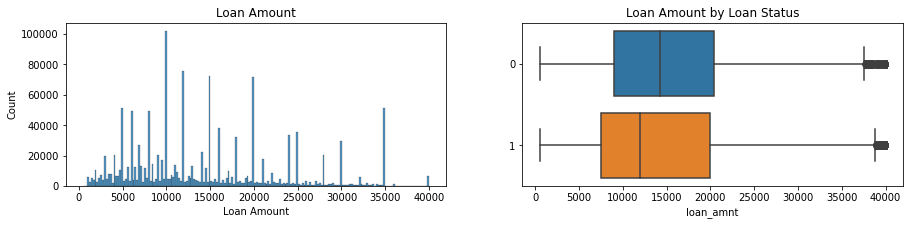

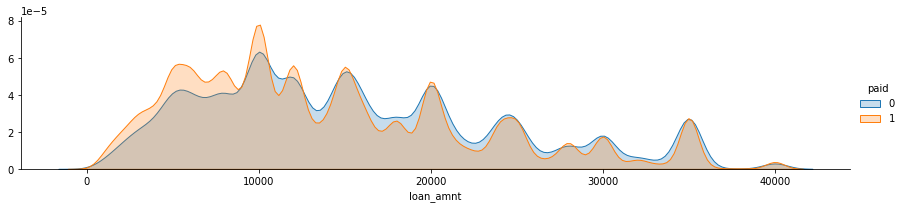

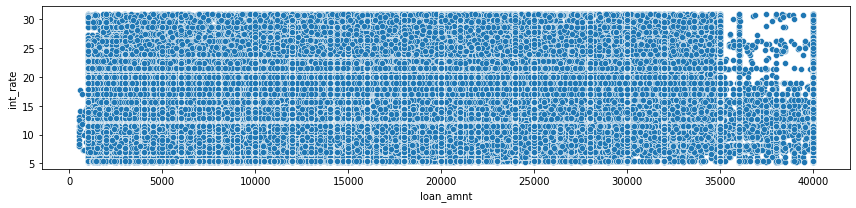

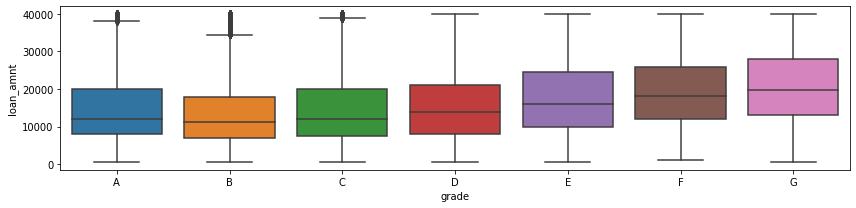

<IPython.core.display.Javascript object>

In [21]:
plot_var("loan_amnt", "Loan Amount", continuous=True)

With loan amount increase, there seems to be a higher chance to get a loan Charged Off. Grade is also decreasing from A to G as loan amount increases.

#### term

In [22]:
description["term"]

'The number of payments on the loan. Values are in months and can be either 36 or 60.'

<IPython.core.display.Javascript object>

In [23]:
lend_club_df["term"].value_counts()

 36 months    1023206
 60 months     324893
Name: term, dtype: int64

<IPython.core.display.Javascript object>

In [24]:
# convert column to integer
lend_club_df["term"] = lend_club_df["term"].apply(lambda s: np.int8(s.split()[0]))

<IPython.core.display.Javascript object>

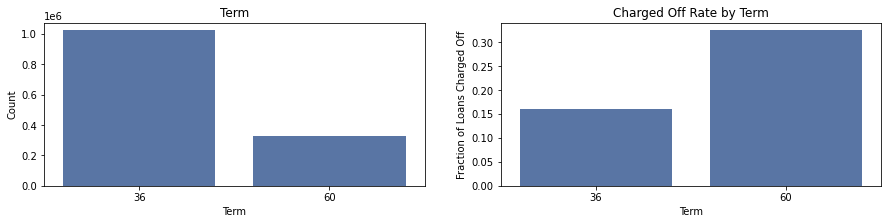

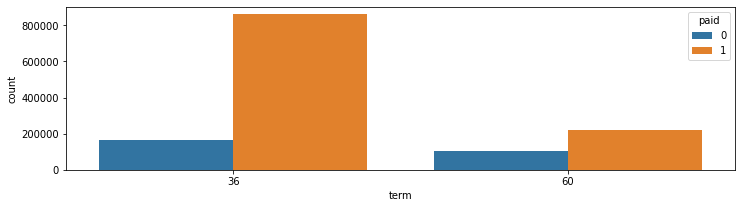

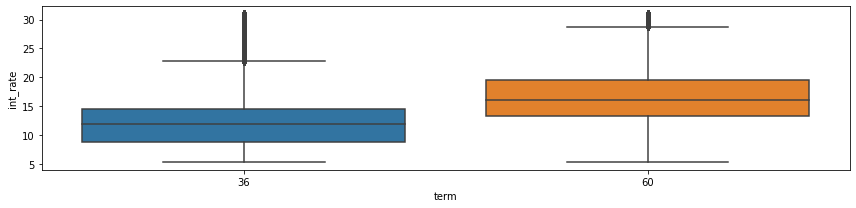

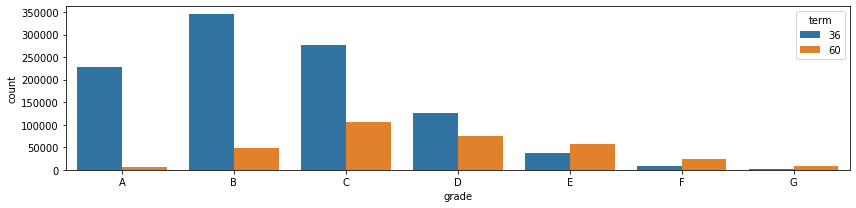

<IPython.core.display.Javascript object>

In [25]:
plot_var(
    "term", "Term", continuous=False,
)

Seems like longer term loans have higher probability to charge off. Interest rate is also higher for those loans with term 60. Also, loans with 60 month term tends to havel lower grade.

#### int_rate

In [26]:
description["int_rate"]

'Interest Rate on the loan'

<IPython.core.display.Javascript object>

In [27]:
lend_club_df["int_rate"].describe()

count   1348099.00
mean         13.24
std           4.77
min           5.31
25%           9.75
50%          12.74
75%          15.99
max          30.99
Name: int_rate, dtype: float64

<IPython.core.display.Javascript object>

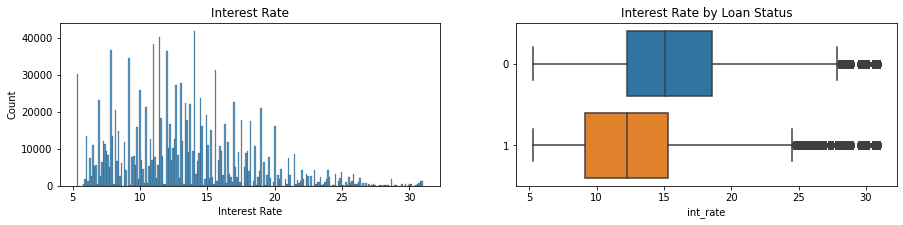

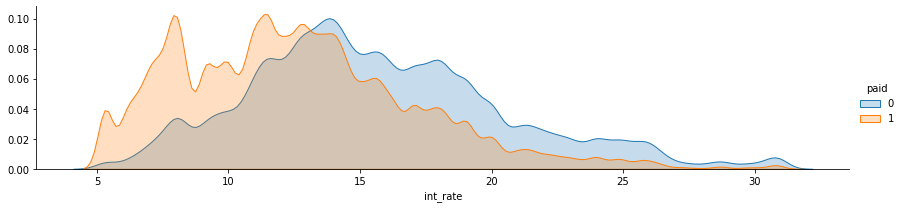

<IPython.core.display.Javascript object>

In [28]:
plot_var("int_rate", "Interest Rate", continuous=True, target=True)

When interest rate is higher than ~13 (mean int_rate) number of fully paid loans drastically increases. Some outliers can be seen on boxplot for Fully Paid loans, will analyse that later.

#### installment

In [29]:
description["installment"]

'The monthly payment owed by the borrower if the loan originates.'

<IPython.core.display.Javascript object>

In [30]:
lend_club_df["installment"].describe()

count   1348099.00
mean        437.78
std         261.50
min           4.93
25%         248.28
50%         375.04
75%         580.22
max        1719.83
Name: installment, dtype: float64

<IPython.core.display.Javascript object>

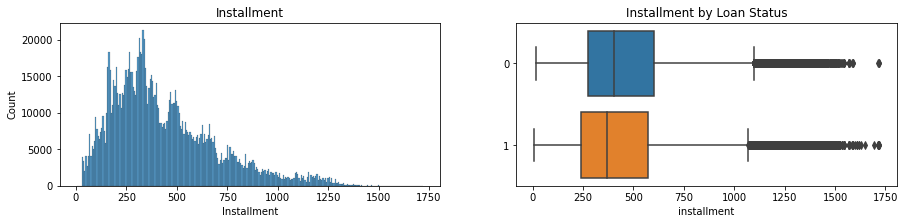

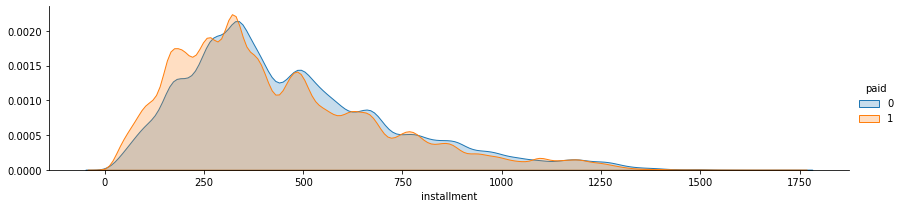

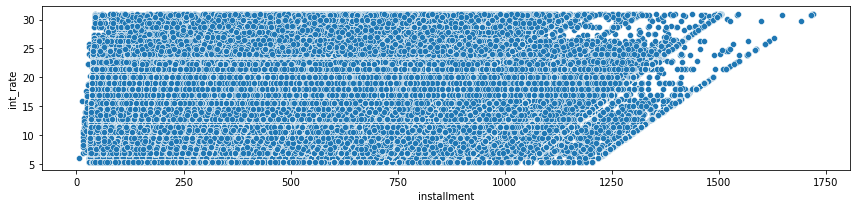

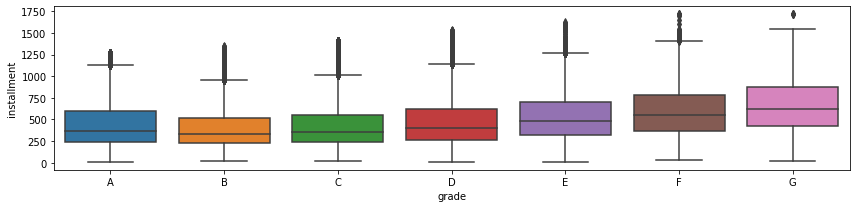

<IPython.core.display.Javascript object>

In [31]:
plot_var("installment", "Installment", continuous=True)

There is a slight tendency for Charged Off loans to have a higher installments number, but it does not seem significant. Interestengly after installment of 1k, interest rate becomes stably high.

#### grade

In [32]:
description["grade"]

'LC assigned loan grade'

<IPython.core.display.Javascript object>

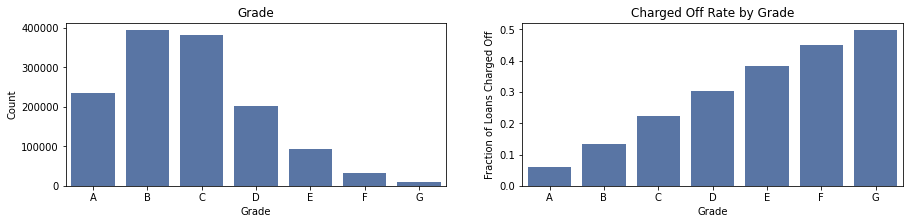

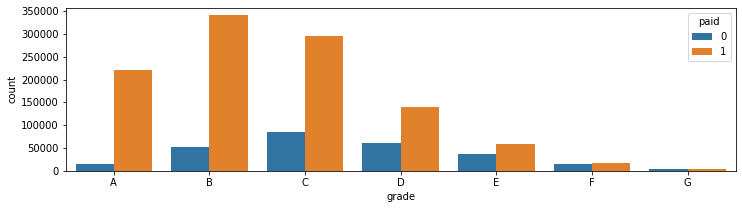

<IPython.core.display.Javascript object>

In [33]:
plot_var("grade", "Grade", continuous=False, target=True)

There is a trend of higher fraction of loans Charged off as the grade going from A to G

#### sub_grade

In [34]:
description["sub_grade"]

'LC assigned loan subgrade'

<IPython.core.display.Javascript object>

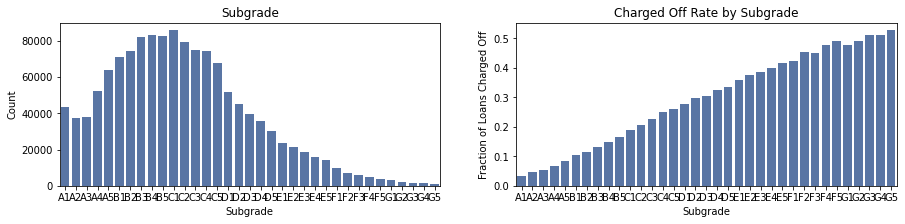

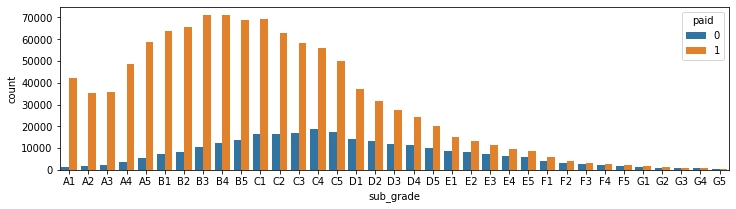

<IPython.core.display.Javascript object>

In [35]:
plot_var("sub_grade", "Subgrade", continuous=False, target=True)

Sub grade is partially derived from Grade, so it follows the same pattern.

#### emp_length

In [36]:
description["emp_length"]

'Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. '

<IPython.core.display.Javascript object>

In [37]:
lend_club_df["emp_length"].value_counts(dropna=False)

10+ years    442679
2 years      122100
< 1 year     108537
3 years      107868
1 year        88843
5 years       84326
4 years       80763
NaN           78550
6 years       62879
8 years       60811
7 years       59724
9 years       51019
Name: emp_length, dtype: int64

<IPython.core.display.Javascript object>

In [38]:
# replace 10+ to 10, < 1 year to 0, nan values to 0
lend_club_df["emp_length"].replace(
    to_replace={"10+ years": "10 years", "< 1 year": "0 years", np.nan: "0 years"},
    inplace=True,
)
# convert to float number
lend_club_df["emp_length"] = lend_club_df["emp_length"].map(
    lambda x: float(str(x).split()[0])
)

lend_club_df["emp_length"].value_counts()

10.00    442679
0.00     187087
2.00     122100
3.00     107868
1.00      88843
5.00      84326
4.00      80763
6.00      62879
8.00      60811
7.00      59724
9.00      51019
Name: emp_length, dtype: int64

<IPython.core.display.Javascript object>

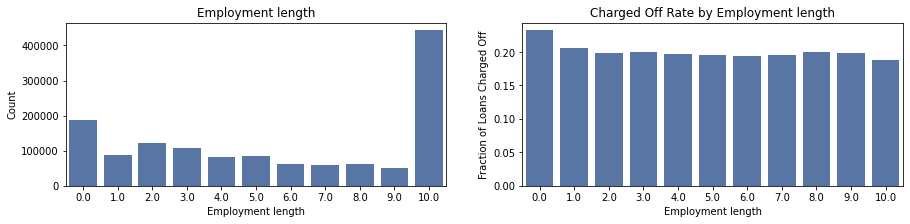

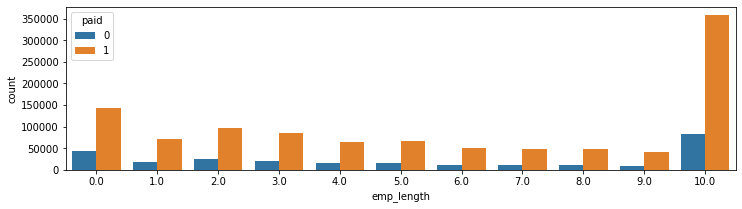

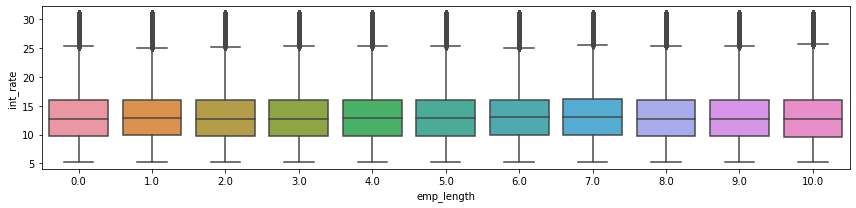

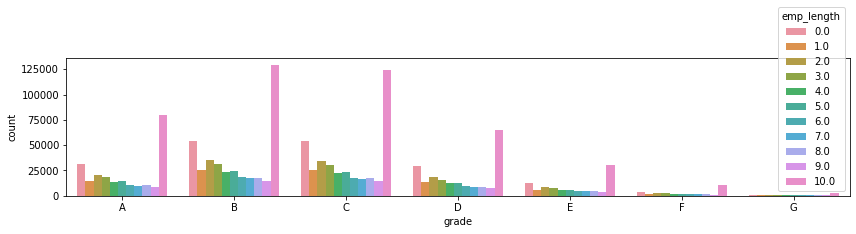

<IPython.core.display.Javascript object>

In [39]:
plot_var("emp_length", "Employment length", continuous=False)

Clients with 10+ years of employment tend to take more loans, clients without employment experience seems to have a little higher charged off rate. No strong effect on interest rate and grade.

#### home_ownership

In [40]:
description["home_ownership"]

'The home ownership status provided by the borrower during registration\xa0or obtained from the credit report.\xa0Our values are: RENT, OWN, MORTGAGE, OTHER'

<IPython.core.display.Javascript object>

In [41]:
lend_club_df["home_ownership"].value_counts()

MORTGAGE    666852
RENT        535699
OWN         145027
ANY            286
OTHER          182
NONE            53
Name: home_ownership, dtype: int64

<IPython.core.display.Javascript object>

In [42]:
# Replace "ANY" & "None" with "OTHER".
lend_club_df["home_ownership"].replace(["NONE", "ANY"], "OTHER", inplace=True)

<IPython.core.display.Javascript object>

In [43]:
lend_club_df.isnull().sum()

loan_amnt                    0
term                         0
int_rate                     0
installment                  0
grade                        0
sub_grade                    0
emp_length                   0
home_ownership               0
annual_inc                   4
verification_status          0
purpose                      0
addr_state                   0
dti                        374
fico_range_low               0
fico_range_high              0
open_acc                    29
pub_rec                     29
total_acc                   29
initial_list_status          0
policy_code                  0
application_type             0
mo_sin_old_il_acct      108325
mo_sin_old_rev_tl_op     70277
mort_acc                 50030
pub_rec_bankruptcies      1365
paid                         0
dtype: int64

<IPython.core.display.Javascript object>

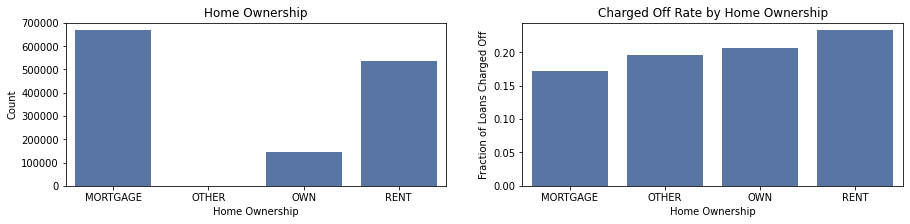

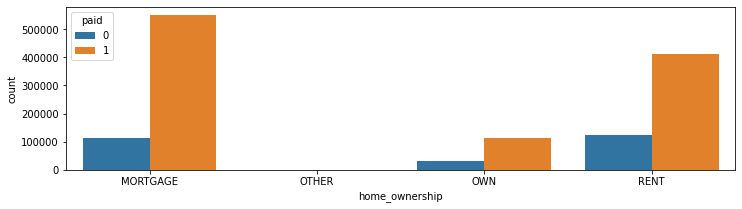

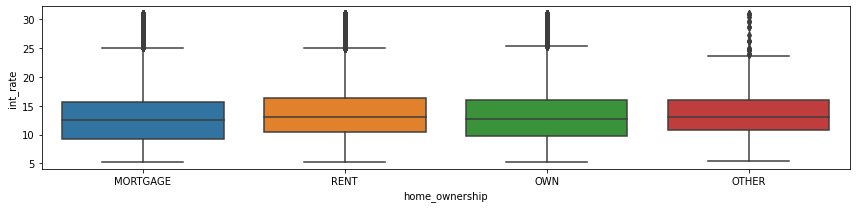

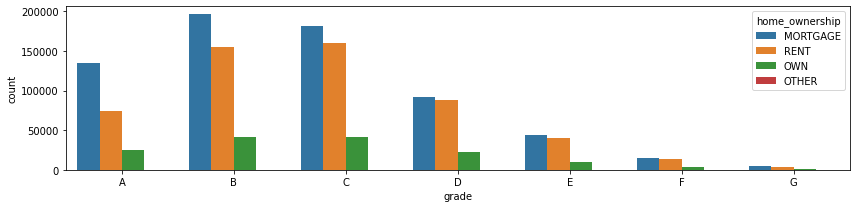

<IPython.core.display.Javascript object>

In [44]:
plot_var("home_ownership", "Home Ownership", continuous=False)

RENT seems to be most risky group to Charge Off here.

#### annual_inc

In [45]:
description["annual_inc"]

'The self-reported annual income provided by the borrower during registration.'

<IPython.core.display.Javascript object>

In [46]:
lend_club_df["annual_inc"].describe()

count    1348095.00
mean       76237.74
std        69922.74
min            0.00
25%        45750.00
50%        65000.00
75%        90000.00
max     10999200.00
Name: annual_inc, dtype: float64

<IPython.core.display.Javascript object>

Annual income ranges from 0 to 11M, with a median at $65k, which seems to be nearly true comparing to Economic data of those years(https://fred.stlouisfed.org/series/MEHOINUSA646N). However, due to the large range of variation, we log-transform the values.

In [47]:
lend_club_df["annual_inc"] = lend_club_df["annual_inc"].apply(lambda x: np.log10(x + 1))

<IPython.core.display.Javascript object>

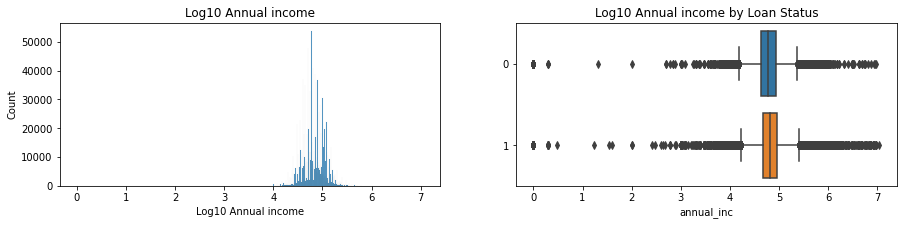

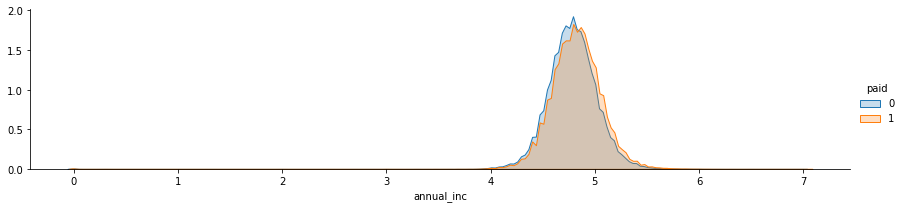

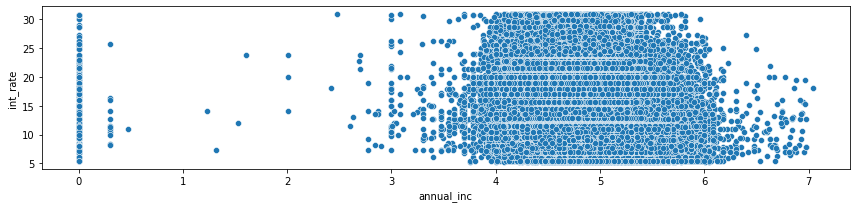

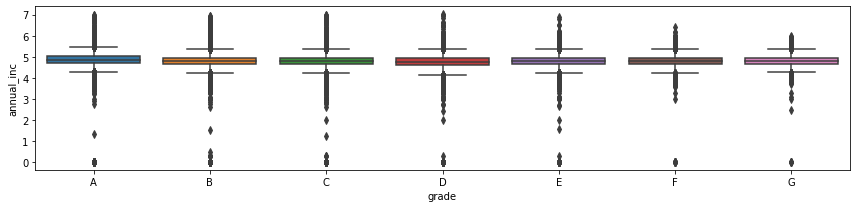

<IPython.core.display.Javascript object>

In [48]:
plot_var("annual_inc", "Log10 Annual income", continuous=True)

There are quite a few outliers, we might get rid of them for our model to be more correct, however lose on those somewhat rare occasions, to be decided when dealing with outliers.

#### verification_status

In [49]:
description["verification_status"]

'Indicates if income was verified by LC, not verified, or if the income source was verified'

<IPython.core.display.Javascript object>

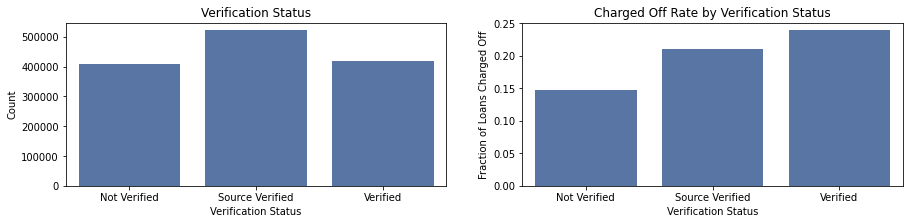

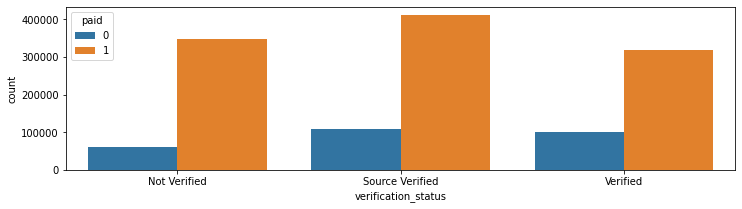

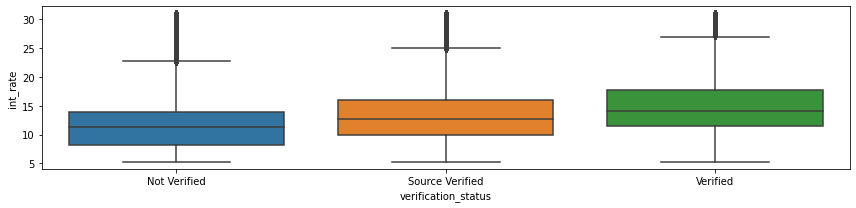

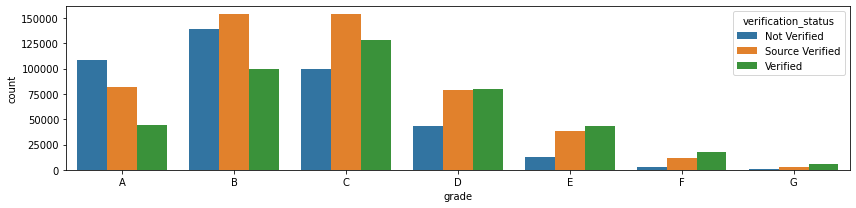

<IPython.core.display.Javascript object>

In [50]:
plot_var("verification_status", "Verification Status", continuous=False)

Unexpectedly 'Verified' loans have higher fraction of Charged Off loans, as well as higher interest rate.

#### purpose

In [51]:
description["purpose"]

'A category provided by the borrower for the loan request. '

<IPython.core.display.Javascript object>

In [52]:
lend_club_df["purpose"].value_counts()

debt_consolidation    781442
credit_card           295625
home_improvement       87721
other                  78301
major_purchase         29550
medical                15614
small_business         15577
car                    14652
moving                  9526
vacation                9084
house                   7298
wedding                 2350
renewable_energy         936
educational              423
Name: purpose, dtype: int64

<IPython.core.display.Javascript object>

Check for charged-off rates of each purpose

In [53]:
lend_club_df.groupby("purpose")["paid"].value_counts(normalize=True)[:, 0].sort_values(
    ascending=False
)

purpose
small_business       0.30
renewable_energy     0.24
moving               0.23
house                0.22
medical              0.22
debt_consolidation   0.21
other                0.21
educational          0.21
vacation             0.19
major_purchase       0.19
home_improvement     0.18
credit_card          0.17
car                  0.15
wedding              0.12
Name: paid, dtype: float64

<IPython.core.display.Javascript object>

30% of loans for small businesses are charged off, seems like a riskiest group and it makes sense. Wedding is the less risky though.

#### addr_state

In [54]:
description["addr_state"]

'The state provided by the borrower in the loan application'

<IPython.core.display.Javascript object>

In [55]:
lend_club_df["addr_state"].describe()

count     1348099
unique         51
top            CA
freq       196853
Name: addr_state, dtype: object

<IPython.core.display.Javascript object>

In [56]:
lend_club_df.groupby("addr_state")["paid"].value_counts(normalize=True)[
    :, 0
].sort_values(ascending=True)

addr_state
DC   0.13
ME   0.14
VT   0.14
OR   0.14
NH   0.15
WV   0.16
CO   0.16
WA   0.16
SC   0.16
WY   0.17
KS   0.17
MT   0.17
UT   0.17
CT   0.17
RI   0.18
IL   0.18
WI   0.18
GA   0.18
ID   0.19
MA   0.19
CA   0.20
AK   0.20
AZ   0.20
DE   0.20
MN   0.20
TX   0.20
VA   0.20
HI   0.20
MI   0.20
ND   0.20
OH   0.21
NC   0.21
PA   0.21
KY   0.21
NJ   0.21
SD   0.21
MD   0.21
MO   0.21
NM   0.21
TN   0.21
IA   0.21
IN   0.21
FL   0.22
NV   0.22
NY   0.22
LA   0.23
OK   0.23
AL   0.24
AR   0.24
NE   0.25
MS   0.26
Name: paid, dtype: float64

<IPython.core.display.Javascript object>

MS has the highest fraction of Charged Off (0.26), whereas DC has the lowest fraction at 0.13. This might be helpful when encoding values for modelling

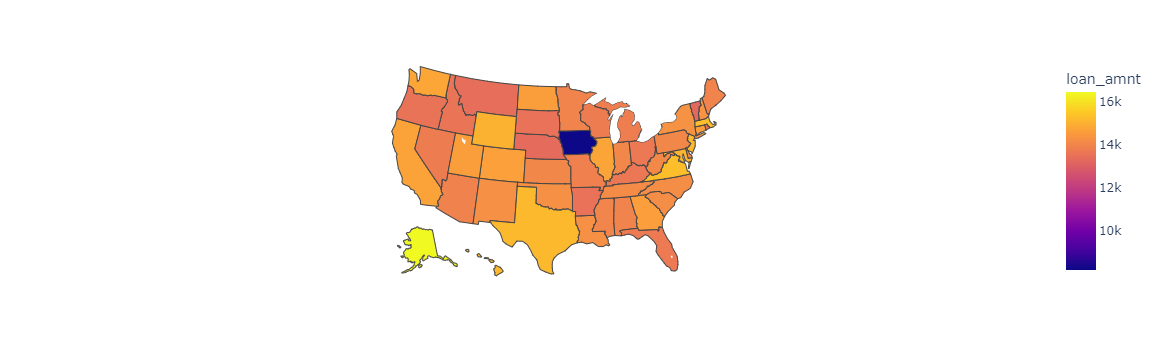

<IPython.core.display.Javascript object>

In [57]:
fig = px.choropleth(
    lend_club_df.groupby("addr_state")["loan_amnt"].mean().reset_index(),
    locations="addr_state",
    locationmode="USA-states",
    scope="usa",
    color="loan_amnt",
)

fig.show()

#### dti

In [58]:
description["dti"]

'A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.'

<IPython.core.display.Javascript object>

In [59]:
lend_club_df["dti"].describe()

count   1347725.00
mean         18.27
std          11.16
min          -1.00
25%          11.79
50%          17.61
75%          24.05
max         999.00
Name: dti, dtype: float64

<IPython.core.display.Javascript object>

DTI values range from -1 to 999, which looks like outliers. 

In [60]:
(lend_club_df["dti"] > 50).sum()

2774

<IPython.core.display.Javascript object>

According to articles on DTI (e.g. https://www.citizensbank.com/learning/how-much-debt-is-too-much.aspx#:~:text=Debt%2Dto%2Dincome%20ratio%20is,to%20be%20too%20much%20debt._) >43% dti value is a too high dti, however in our dataset we have 2.7k records with dti even higher than that. We will kep records with dti <100% just to get model learn those special cases, but remove those higher than 100%.

In [61]:
lend_club_df = lend_club_df[lend_club_df["dti"] < 100]

<IPython.core.display.Javascript object>

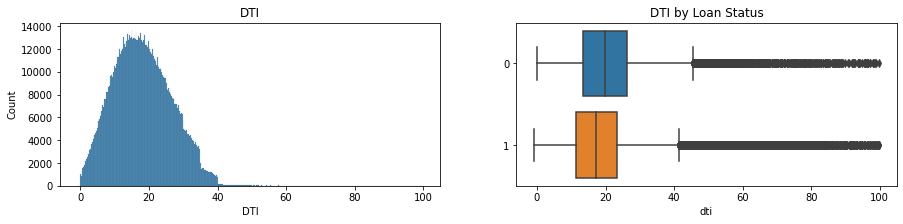

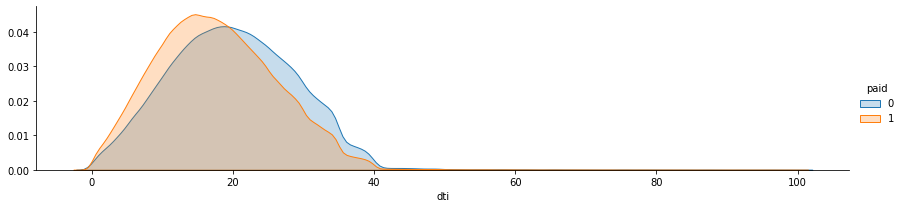

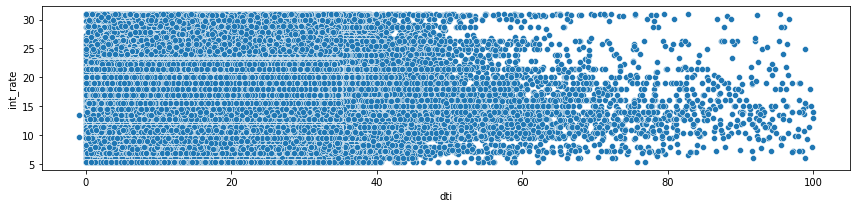

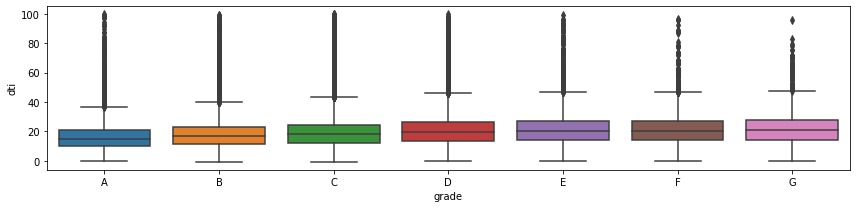

<IPython.core.display.Javascript object>

In [62]:
plot_var("dti", "DTI", continuous=True)

In [63]:
lend_club_df.groupby("paid")["dti"].mean()

paid
0   20.03
1   17.71
Name: dti, dtype: float64

<IPython.core.display.Javascript object>

Clearly borrowers with higher DTI are more likely to Charge off. Grade is also decreasing with higher dti (not significant)

#### fico_range_low, fico_range_high

In [64]:
description["fico_range_low"]

'The lower boundary range the borrower’s FICO at loan origination belongs to.'

<IPython.core.display.Javascript object>

In [65]:
description["fico_range_high"]

'The upper boundary range the borrower’s FICO at loan origination belongs to.'

<IPython.core.display.Javascript object>

In [66]:
lend_club_df[["fico_range_low", "fico_range_high"]].describe()

fico_range_low  fico_range_high
count      1347190.00       1347190.00
mean           696.16           700.16
std             31.85            31.85
min            610.00           614.00
25%            670.00           674.00
50%            690.00           694.00
75%            710.00           714.00
max            845.00           850.00

<IPython.core.display.Javascript object>

Lets check for the correlation of these two.

In [67]:
lend_club_df[["fico_range_low", "fico_range_high"]].corr()

fico_range_low  fico_range_high
fico_range_low             1.00             1.00
fico_range_high            1.00             1.00

<IPython.core.display.Javascript object>

Perfect correlation, keeping the average fico value should work.

In [68]:
lend_club_df["fico"] = (
    lend_club_df["fico_range_low"] + lend_club_df["fico_range_high"]
) / 2

<IPython.core.display.Javascript object>

In [69]:
lend_club_df.drop(["fico_range_low", "fico_range_high"], axis=1, inplace=True)

<IPython.core.display.Javascript object>

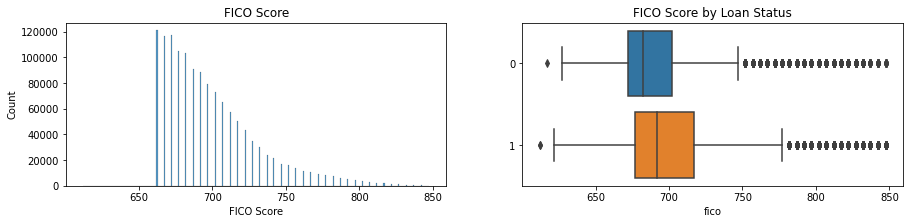

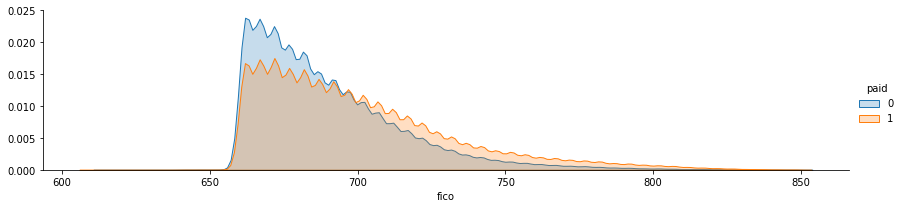

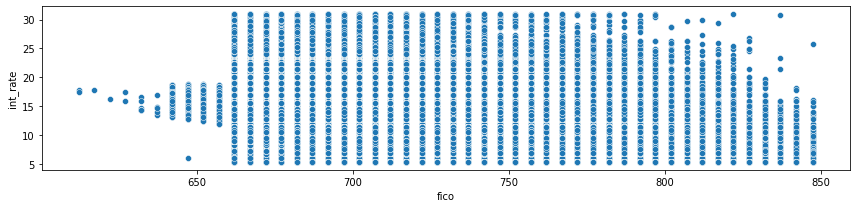

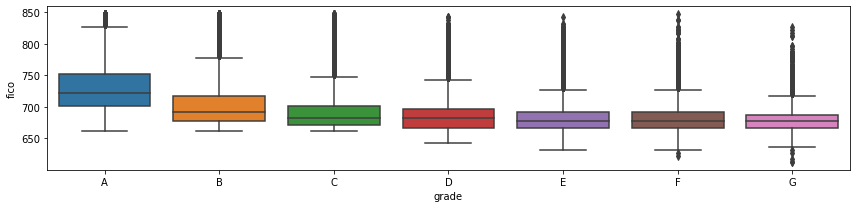

<IPython.core.display.Javascript object>

In [70]:
plot_var("fico", "FICO Score", continuous=True)

We can see that borrowers who has charged off tend to have lower FICO score on average. FICO score seems to be an important feature in this case. Lower interest rate with high FICO score, as well as it seems FICO score is very important for grading, as most of high FICO scores got A grade.

#### open_acc

In [71]:
description["open_acc"]

"The number of open credit lines in the borrower's credit file."

<IPython.core.display.Javascript object>

In [72]:
lend_club_df["open_acc"].describe()

count   1347161.00
mean         11.59
std           5.47
min           0.00
25%           8.00
50%          11.00
75%          14.00
max          90.00
Name: open_acc, dtype: float64

<IPython.core.display.Javascript object>

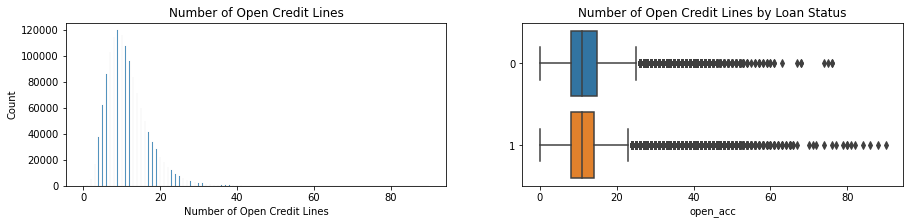

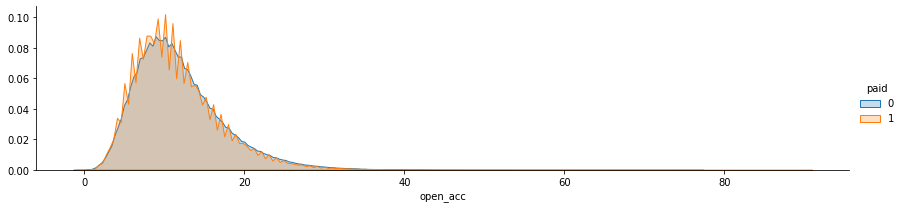

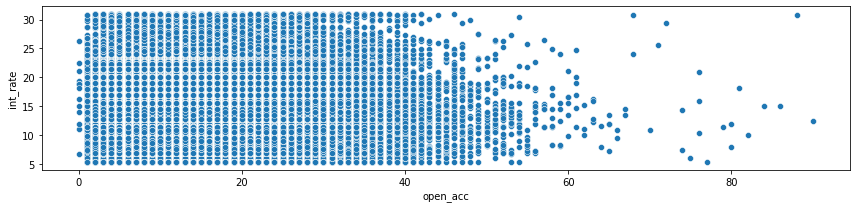

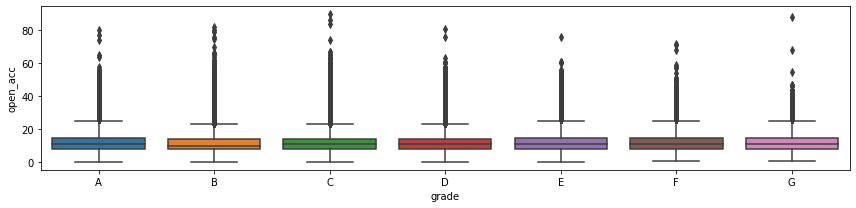

<IPython.core.display.Javascript object>

In [73]:
plot_var("open_acc", "Number of Open Credit Lines", continuous=True)

No difference in number of credit line between fully paid and charged off loans

#### pub_rec

In [74]:
description["pub_rec"]

'Number of derogatory public records'

<IPython.core.display.Javascript object>

In [75]:
lend_club_df["pub_rec"].describe()

count   1347161.00
mean          0.22
std           0.60
min           0.00
25%           0.00
50%           0.00
75%           0.00
max          86.00
Name: pub_rec, dtype: float64

<IPython.core.display.Javascript object>

In [76]:
lend_club_df["pub_rec"].value_counts()

0.00     1119156
1.00      190900
2.00       24439
3.00        7403
4.00        2630
5.00        1267
6.00         636
7.00         283
8.00         160
9.00          83
10.00         57
11.00         40
12.00         27
13.00         18
15.00          9
21.00          6
18.00          6
16.00          5
19.00          5
14.00          5
20.00          3
28.00          3
17.00          3
22.00          2
49.00          2
24.00          2
34.00          1
46.00          1
47.00          1
61.00          1
40.00          1
54.00          1
86.00          1
63.00          1
23.00          1
25.00          1
37.00          1
Name: pub_rec, dtype: int64

<IPython.core.display.Javascript object>

Most of the records has 0 public records, try to group higher values to value 3.

In [77]:
lend_club_df.pub_rec = lend_club_df.pub_rec.map(lambda x: 3 if x > 2.0 else x)

<IPython.core.display.Javascript object>

In [78]:
lend_club_df["pub_rec"].value_counts().sort_values(ascending=False)

0.00    1119156
1.00     190900
2.00      24439
3.00      12666
Name: pub_rec, dtype: int64

<IPython.core.display.Javascript object>

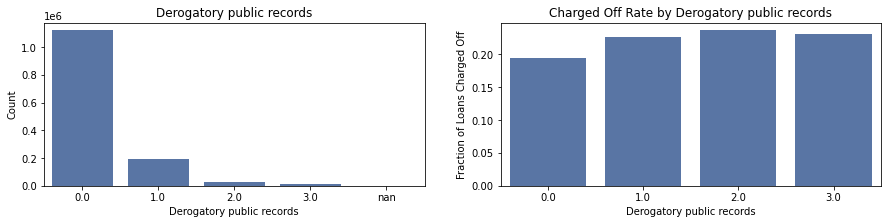

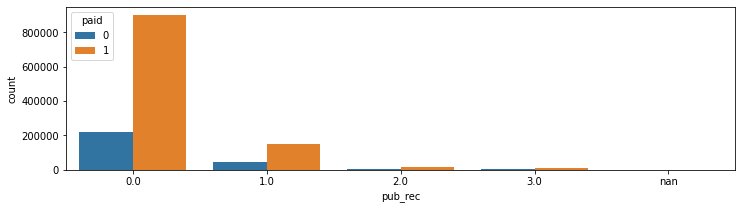

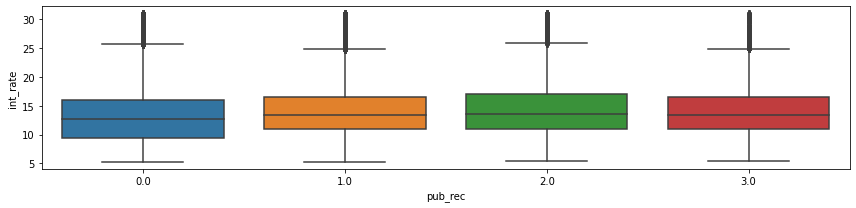

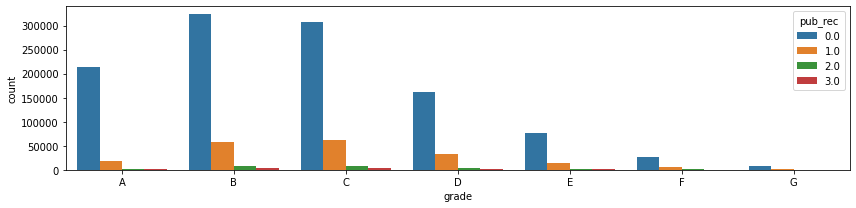

<IPython.core.display.Javascript object>

In [79]:
plot_var("pub_rec", "Derogatory public records", continuous=False)

There is a slight tendency when pub_rec is 1 and higher to have a higher Charged Off probability.

#### pub_rec_bankruptcies

In [80]:
description["pub_rec_bankruptcies"]

'Number of public record bankruptcies'

<IPython.core.display.Javascript object>

In [81]:
lend_club_df["pub_rec_bankruptcies"].value_counts()

0.00     1178121
1.00      157741
2.00        7768
3.00        1583
4.00         396
5.00         141
6.00          46
7.00          15
8.00           9
9.00           3
12.00          1
11.00          1
Name: pub_rec_bankruptcies, dtype: int64

<IPython.core.display.Javascript object>

In [82]:
lend_club_df[["pub_rec", "pub_rec_bankruptcies"]].corr()

pub_rec  pub_rec_bankruptcies
pub_rec                  1.00                  0.74
pub_rec_bankruptcies     0.74                  1.00

<IPython.core.display.Javascript object>

Pub_rec and pub_rec_bankrupties have a pretty high correlation, so lets drop one of them.

In [83]:
lend_club_df.drop("pub_rec_bankruptcies", axis=1, inplace=True)

<IPython.core.display.Javascript object>

#### total_acc

In [84]:
description["total_acc"]

"The total number of credit lines currently in the borrower's credit file"

<IPython.core.display.Javascript object>

In [85]:
lend_club_df["total_acc"].describe()

count   1347161.00
mean         24.98
std          12.00
min           1.00
25%          16.00
50%          23.00
75%          32.00
max         176.00
Name: total_acc, dtype: float64

<IPython.core.display.Javascript object>

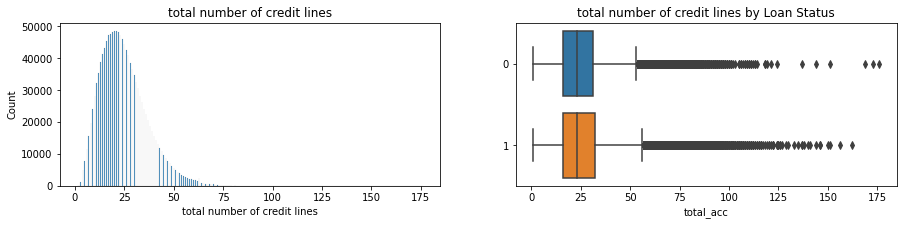

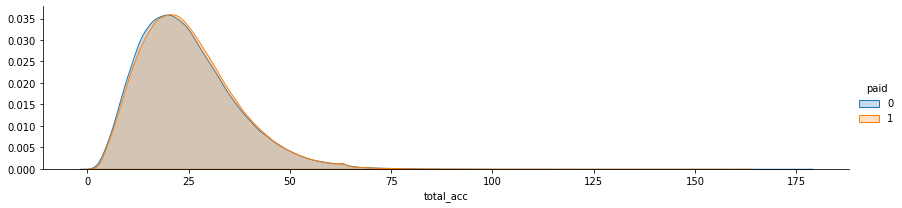

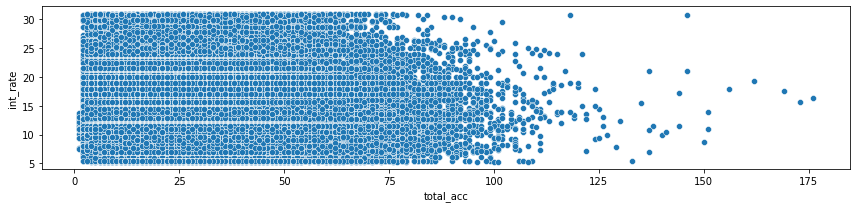

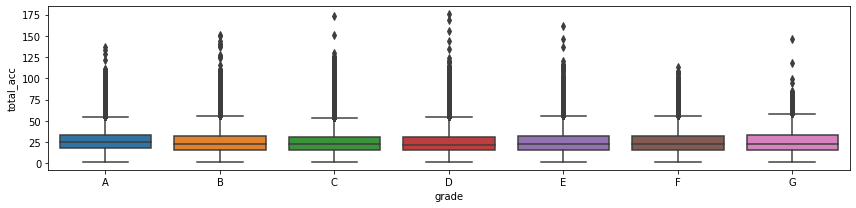

<IPython.core.display.Javascript object>

In [86]:
plot_var("total_acc", "total number of credit lines", continuous=True)

No difference here, outliers will be dealt later.

#### initial_list_status

In [87]:
description["initial_list_status"]

'The initial listing status of the loan. Possible values are – W, F'

<IPython.core.display.Javascript object>

In [88]:
lend_club_df["initial_list_status"].value_counts()

w    783305
f    563885
Name: initial_list_status, dtype: int64

<IPython.core.display.Javascript object>

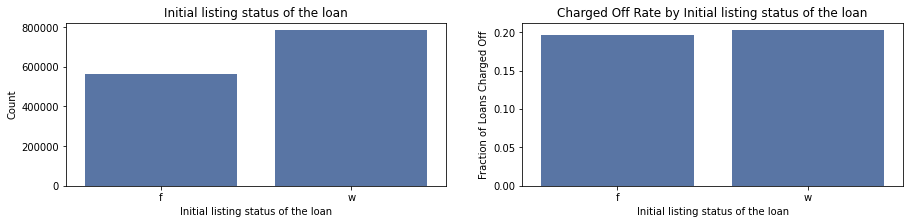

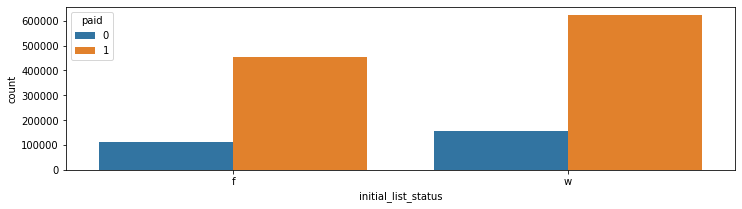

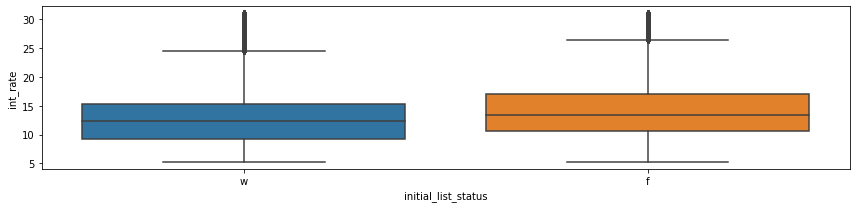

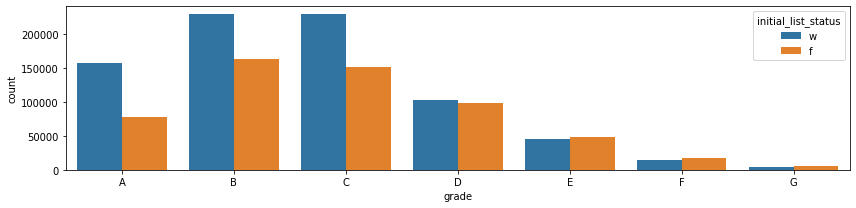

<IPython.core.display.Javascript object>

In [89]:
plot_var("initial_list_status", "Initial listing status of the loan", continuous=False)

Interest rate is higher for 'f' status

#### policy_code

In [90]:
description["policy_code"]

'publicly available policy_code=1\nnew products not publicly available policy_code=2'

<IPython.core.display.Javascript object>

In [91]:
lend_club_df["policy_code"].value_counts()

1.00    1347190
Name: policy_code, dtype: int64

<IPython.core.display.Javascript object>

All values are the same, we can drop this feature

In [92]:
lend_club_df.drop("policy_code", axis=1, inplace=True)

<IPython.core.display.Javascript object>

#### application_type

In [93]:
description["application_type"]

'Indicates whether the loan is an individual application or a joint application with two co-borrowers'

<IPython.core.display.Javascript object>

In [94]:
lend_club_df["application_type"].value_counts()

Individual    1322293
Joint App       24897
Name: application_type, dtype: int64

<IPython.core.display.Javascript object>

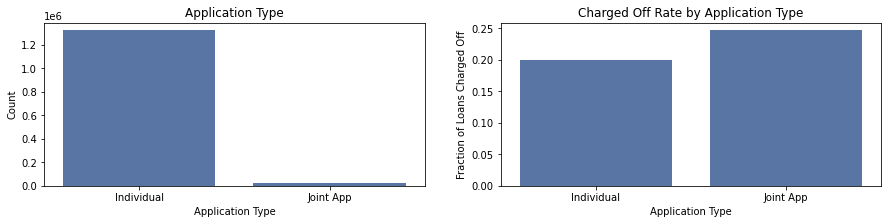

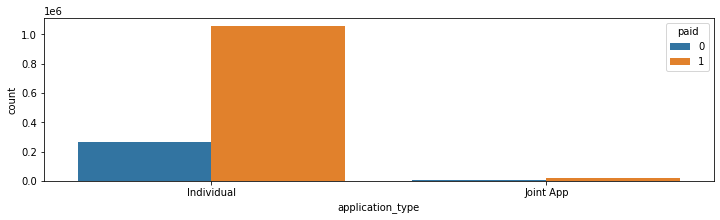

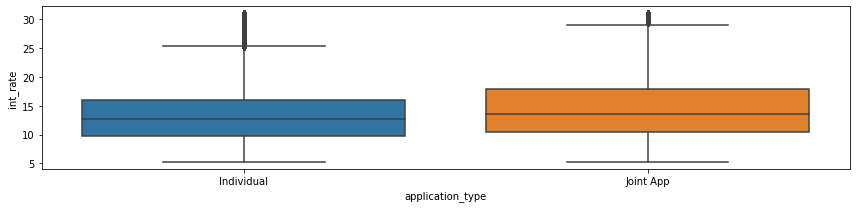

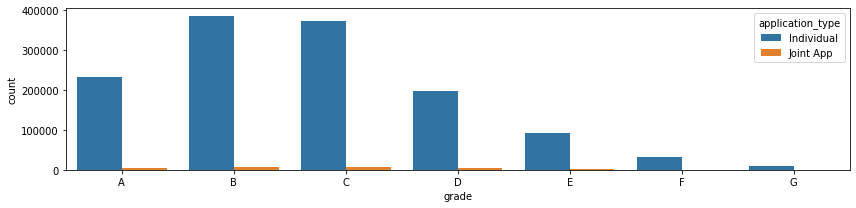

<IPython.core.display.Javascript object>

In [95]:
plot_var("application_type", "Application Type", continuous=False)

Most of the loans in this dataset are of individual type, and it seems like Joint App loans are more likely to be Charged off, however my belief is other way round, though statistic inference will be performed.

### Statistical significance #1. Is the mean value of 'paid' significantly higher for Individual loans than Joint App (is it less likely to be Charged Off)?

H0 - no difference in Charge Off likeliness

Ha - there is difference in Charge Off likeliness

In [96]:
individual_loan = (
    lend_club_df[lend_club_df["application_type"] == "Individual"]["paid"].sample(
        n=7000, random_state=1
    )
).astype(int)
joint_loan = (
    lend_club_df[lend_club_df["application_type"] == "Joint App"]["paid"].sample(
        n=7000, random_state=1
    )
).astype(int)

<IPython.core.display.Javascript object>

In [97]:
print(
    f"Mean 'paid' value for individual loan: {individual_loan.mean()}, std: {individual_loan.std()}, sample size: {individual_loan.size}"
)
print(
    f"Mean 'paid' value for Joint loan: {joint_loan.mean()}, std: {joint_loan.std()}, sample size: {joint_loan.size}"
)

Mean 'paid' value for individual loan: 0.7911428571428571, std: 0.4065211497903504, sample size: 7000
Mean 'paid' value for Joint loan: 0.7555714285714286, std: 0.42977858484135856, sample size: 7000


<IPython.core.display.Javascript object>

In [98]:
(t_stat, p_val, dof) = sm.stats.ttest_ind(individual_loan, joint_loan)
print(f"p value: {p_val}, t statistics: {t_stat}")

p value: 4.945367308121079e-07, t statistics: 5.030781913617394


<IPython.core.display.Javascript object>

P value is lower than our alpha, thus we can reject the null hypothesis, and as T statistics is positive value, we can confirm that Individual application type is less likely to get Charged Off

#### mo_sin_old_il_acct

In [99]:
description["mo_sin_old_il_acct"]

'Months since oldest bank installment account opened'

<IPython.core.display.Javascript object>

In [100]:
lend_club_df["mo_sin_old_il_acct"].describe()

count   1238901.00
mean        125.80
std          52.23
min           0.00
25%          98.00
50%         129.00
75%         152.00
max         999.00
Name: mo_sin_old_il_acct, dtype: float64

<IPython.core.display.Javascript object>

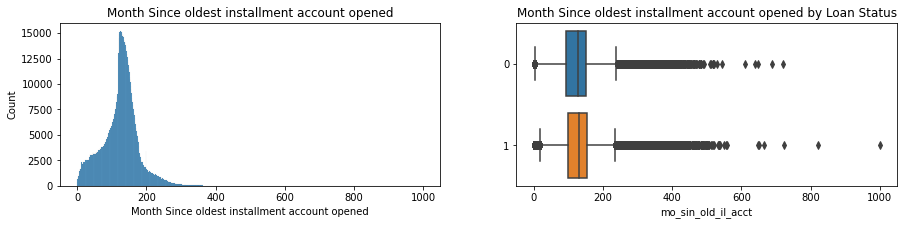

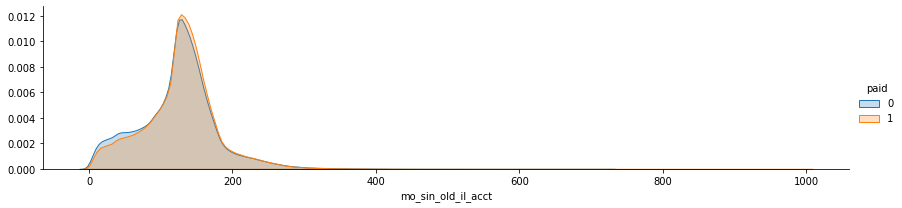

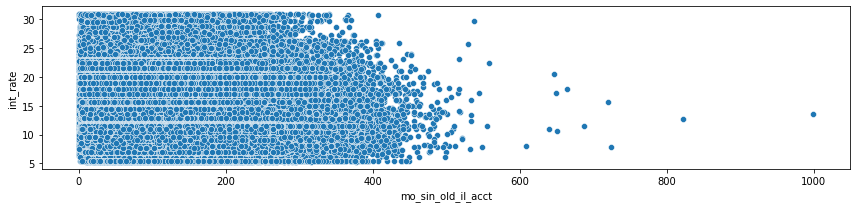

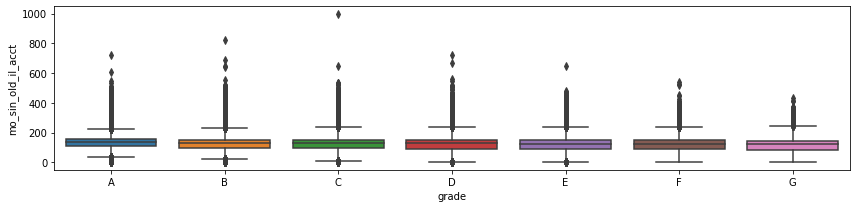

<IPython.core.display.Javascript object>

In [101]:
plot_var(
    "mo_sin_old_il_acct",
    "Month Since oldest installment account opened",
    continuous=True,
)

#### mo_sin_old_rev_tl_op

In [102]:
description["mo_sin_old_rev_tl_op"]

'Months since oldest revolving account opened'

<IPython.core.display.Javascript object>

In [103]:
lend_club_df["mo_sin_old_rev_tl_op"].describe()

count   1276913.00
mean        181.48
std          94.51
min           2.00
25%         117.00
50%         164.00
75%         230.00
max         852.00
Name: mo_sin_old_rev_tl_op, dtype: float64

<IPython.core.display.Javascript object>

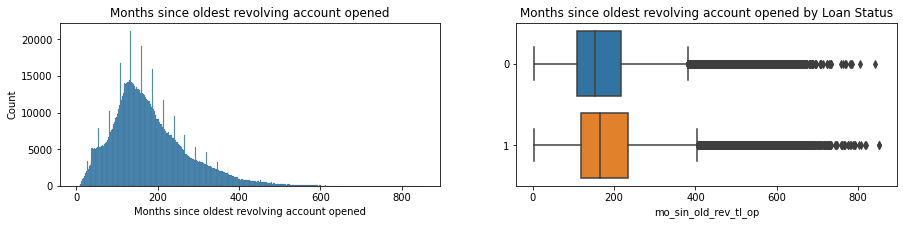

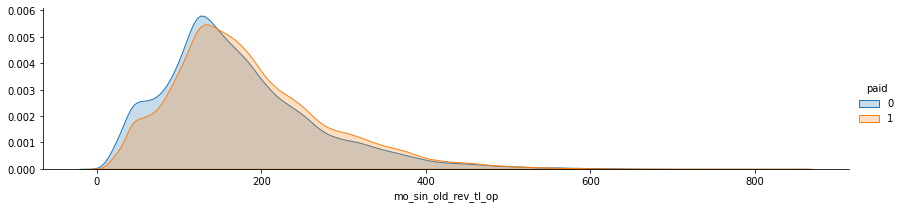

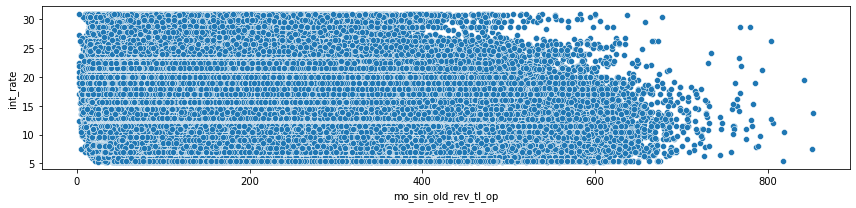

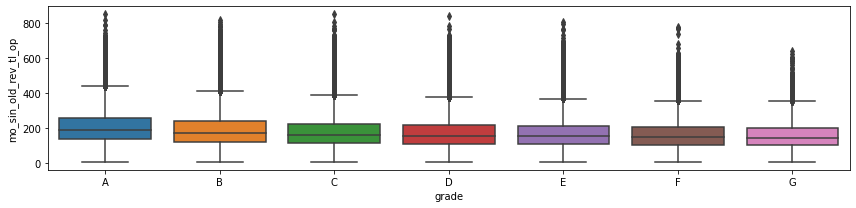

<IPython.core.display.Javascript object>

In [104]:
plot_var(
    "mo_sin_old_rev_tl_op",
    "Months since oldest revolving account opened",
    continuous=True,
)

#### mort_acc

In [105]:
description["mort_acc"]

'Number of mortgage accounts.'

<IPython.core.display.Javascript object>

In [106]:
lend_club_df["mort_acc"].describe()

count   1297160.00
mean          1.67
std           2.00
min           0.00
25%           0.00
50%           1.00
75%           3.00
max          51.00
Name: mort_acc, dtype: float64

<IPython.core.display.Javascript object>

In [107]:
lend_club_df.mort_acc = lend_club_df.mort_acc.map(lambda x: 6.0 if x > 6.0 else x)

<IPython.core.display.Javascript object>

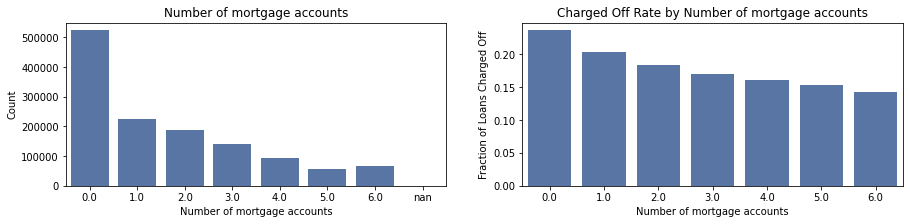

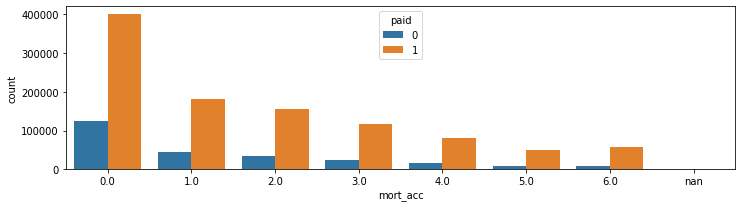

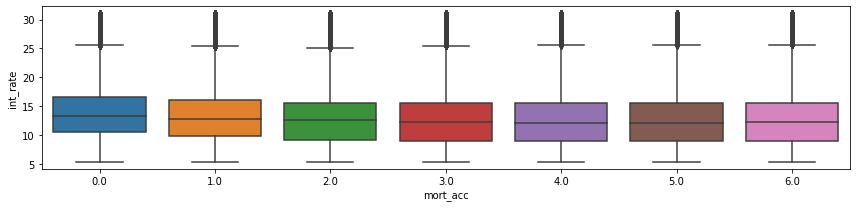

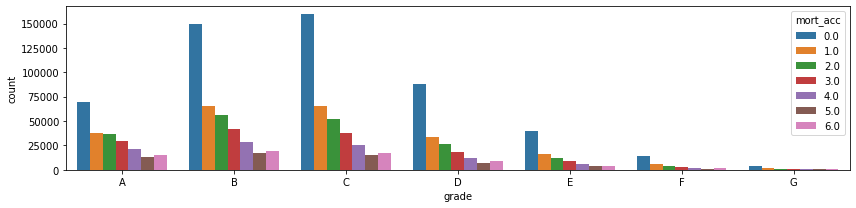

<IPython.core.display.Javascript object>

In [108]:
plot_var("mort_acc", "Number of mortgage accounts", continuous=False)

The more the number of mortgage accounts, the lower fraction of loans charged off.

### Correlation

<AxesSubplot:>

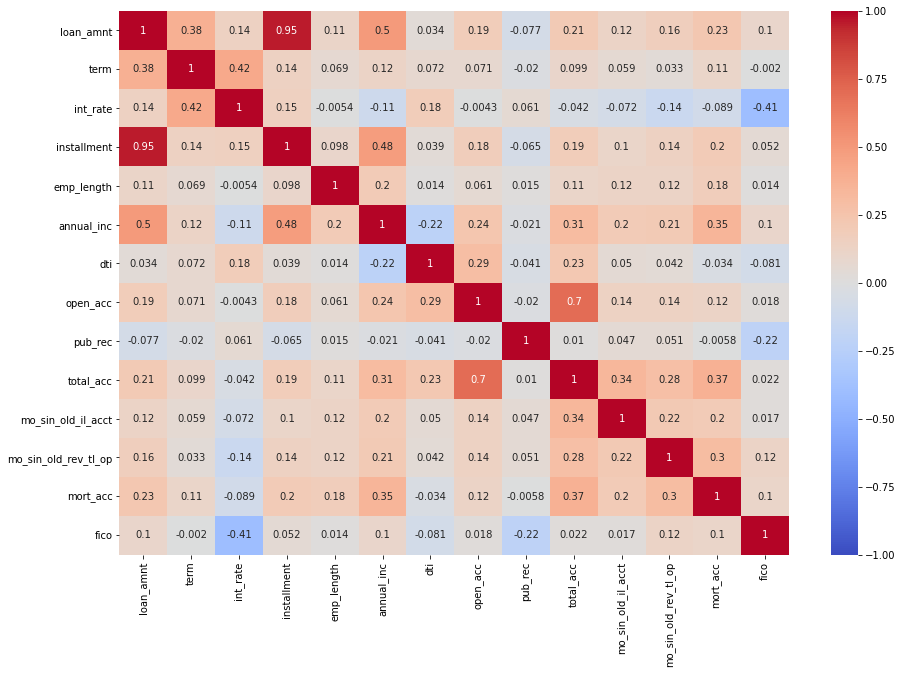

<IPython.core.display.Javascript object>

In [109]:
corr = lend_club_df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)

* Perfect correlation (0.95) between loan amount and installment, as well as annul income(0.48), lets get rid of Installment column.
* Strong positive correlation (0.7) between total accounts and open accounts, and very similar correlations with all other features, so lets keep just one of them (total account)
* Interesting strong negative correlation(-0.41) between FICO and interest rate, the higher FICO rating the lower interest rate. 

In [110]:
lend_club_df.drop(["open_acc", "installment"], axis=1, inplace=True)

<IPython.core.display.Javascript object>

### Handling Null values

In [111]:
lend_club_df.isnull().sum()

loan_amnt                    0
term                         0
int_rate                     0
grade                        0
sub_grade                    0
emp_length                   0
home_ownership               0
annual_inc                   4
verification_status          0
purpose                      0
addr_state                   0
dti                          0
pub_rec                     29
total_acc                   29
initial_list_status          0
application_type             0
mo_sin_old_il_acct      108289
mo_sin_old_rev_tl_op     70277
mort_acc                 50030
paid                         0
fico                         0
dtype: int64

<IPython.core.display.Javascript object>

* Empty annual income field can be its absence, so fill it with 0
* Null values in pub_rec, total_acc, mort_acc could mean that there is no accounts, thus fill with 0
* Null values in mo_sin_old_il_acct and mo_sin_old_rev_tl_op, can be explained as there were no previous accounts (cannot fill with 0 as it would mean there were a very recent account). Try with filling NaN with -1.

In [112]:
values = {
    "annual_inc": 0,
    "pub_rec": 0,
    "total_acc": 0,
    "mort_acc": 0,
    "mo_sin_old_il_acct": -1,
    "mo_sin_old_rev_tl_op": -1,
}
lend_club_df.fillna(value=values, inplace=True)

<IPython.core.display.Javascript object>

### Assumptions

Before going forward, we have to make some assumptions, as we are not working directly with Lending Club, and there are some trivial things that can be misinterpreted. They are:

- We will think of 'rejected' dataset, as correctly rejected cases, and take that into consideration for our model.
- As 'rejected' dataset has only 9 features(comparing to 150+ of 'accepted' data), we will treat those as a decision making point to either accept or reject loan. Thus for the first step, we will construct dataset of both rejected/accepted data, label it, and use only those limited features. This might make our model more accurate and fast.

### Constructing data for step 1

Data seems to be unbalanced, as stated in Assumptions section, 'rejected' data will also be used for this, both to handle the balance problem and possibly gain more information

#### Clean rejected dataframe

In [113]:
def preprocessing(df):
    df.dropna(
        axis=0,
        subset=["loan_amnt", "purpose", "fico", "addr_state"],
        how="all",
        inplace=True,
    )
    df["emp_length"].fillna("0", inplace=True)
    df["emp_length"].replace("< 1 year", "0", inplace=True)
    df["emp_length"] = df["emp_length"].str.strip("<>+ years").astype("float")
    df["purpose"].fillna("other", inplace=True)
    df["fico"].fillna(0, inplace=True)
    if df["dti"].dtype == "O":
        df["dti"] = df["dti"].str.rstrip("%").astype("float")
    df["dti"].fillna(df["dti"].median(), inplace=True)
    df["addr_state"].fillna(df["addr_state"].mode().iloc[0], inplace=True)
    df = df[df["dti"] < 100]
    return df

<IPython.core.display.Javascript object>

In [114]:
def group_purpose(df):
    df.loc[
        df["purpose"].str.contains("|".join(["debt", "consolid"]), case=False),
        "purpose",
    ] = "debt_consolidation"

    df.loc[df["purpose"].str.contains("credit", case=False), "purpose"] = "credit_card"

    df.loc[
        df["purpose"].str.contains("home improve", case=False), "purpose"
    ] = "home_improvement"
    df.loc[
        df["purpose"].str.contains("major", case=False), "purpose"
    ] = "major_purchase"
    df.loc[df["purpose"].str.contains("medical", case=False), "purpose"] = "medical"
    df.loc[
        df["purpose"].str.contains("|".join(["car", "vehicle"]), case=False), "purpose"
    ] = "car"
    df.loc[
        df["purpose"].str.contains("business", case=False), "purpose"
    ] = "small_business"
    df.loc[
        df["purpose"].str.contains("|".join(["vacation", "holiday"]), case=False),
        "purpose",
    ] = "vacation"
    df.loc[df["purpose"].str.contains("moving", case=False), "purpose"] = "moving"
    df.loc[
        df["purpose"].str.contains("|".join(["house", "home buy"]), case=False),
        "purpose",
    ] = "house"
    df.loc[
        df["purpose"].str.contains("energy", case=False), "purpose"
    ] = "renewable_energy"
    df.loc[df["purpose"].str.contains("wedding", case=False), "purpose"] = "wedding"
    df.loc[
        df["purpose"].str.contains(
            "|".join(["education", "learn", "student", "school"]), case=False
        ),
        "purpose",
    ] = "educational"
    df.loc[df["purpose"].str.contains("other", case=False), "purpose"] = "other"
    df.loc[df["purpose"].str.contains("person", case=False), "purpose"] = "personal"

<IPython.core.display.Javascript object>

In [115]:
rejected_df.rename(
    columns={
        "Amount Requested": "loan_amnt",
        "Loan Title": "purpose",
        "Risk_Score": "fico",
        "Debt-To-Income Ratio": "dti",
        "State": "addr_state",
        "Employment Length": "emp_length",
    },
    inplace=True,
)

<IPython.core.display.Javascript object>

In [116]:
rejected_df = preprocessing(rejected_df)
group_purpose(rejected_df)
rejected_df.drop(
    rejected_df[
        ~rejected_df["purpose"].isin(
            [
                "personal",
                "educational",
                "Green loan",
                "wedding",
                "renewable_energy",
                "vacation",
                "house",
                "moving",
                "medical",
                "small_business",
                "major_purchase",
                "home_improvement",
                "other",
                "car",
                "debt_consolidation",
            ]
        )
    ].index,
    inplace=True,
)
rejected_df = rejected_df[
    ["loan_amnt", "purpose", "fico", "dti", "addr_state", "emp_length",]
].sample(800000)
group_purpose(rejected_df)
rejected_df["paid"] = 0

<IPython.core.display.Javascript object>

In [117]:
first_step_df = lend_club_df[
    ["loan_amnt", "purpose", "fico", "dti", "addr_state", "emp_length", "paid",]
]

<IPython.core.display.Javascript object>

In [118]:
first_step_df = pd.concat([first_step_df, rejected_df], axis=0, ignore_index=True)

<IPython.core.display.Javascript object>

In [119]:
first_step_df["paid"].value_counts()

1    1078044
0    1069146
Name: paid, dtype: int64

<IPython.core.display.Javascript object>

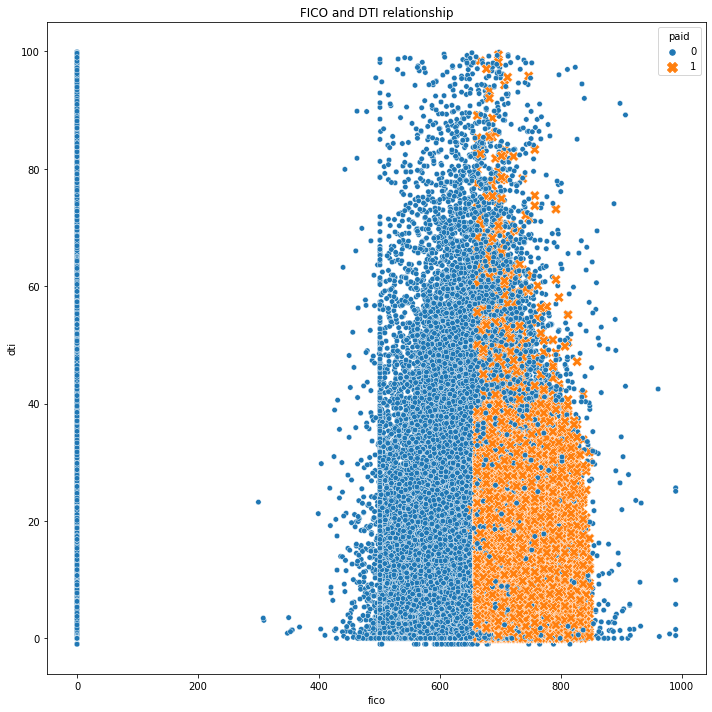

<IPython.core.display.Javascript object>

In [120]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(
    x="fico",
    y="dti",
    hue="paid",
    style="paid",
    size="paid",
    sizes=(100, 30),
    data=first_step_df.sample(300000),
    ax=ax,
)
plt.title("FICO and DTI relationship")
plt.tight_layout()

We can see that most of the Fully Paid loans has a higher FICO score >600 and lower dti <50.

Run a statistical inference on the loan amount with FICO score.

## Statistical significance #2 Is the mean value of loan_amount higher for those who have good FICO score (>740, according to credit data analytics provider Equifax https://www.equifax.com/personal/education/credit/score/what-is-a-good-credit-score/)?

H0 - no difference in loan amount between clients with high fico rating and normal/low

Ha - there is difference in loan amount between clints with high fico rating and normal/low

In [121]:
fico_good = first_step_df[first_step_df["fico"] > 740]["loan_amnt"].sample(
    n=100000, random_state=1
)
fico_norm = first_step_df[first_step_df["fico"] < 740]["loan_amnt"].sample(
    n=100000, random_state=1
)

<IPython.core.display.Javascript object>

In [122]:
print(f"Mean loan amount for good FICO scores: {fico_good.mean()}, std: {fico_good.std()}, sample size: {fico_good.size}")
print(f"Mean loan amount for low/normal FICO scores: {fico_norm.mean()}, std: {fico_norm.std()}, sample size: {fico_norm.size}")


Mean loan amount for good FICO scores: 15530.48575, std: 9665.692278946999, sample size: 100000
Mean loan amount for low/normal FICO scores: 13783.14225, std: 12103.151370517402, sample size: 100000


<IPython.core.display.Javascript object>

In [123]:
(t_stat, p_val, dof) = sm.stats.ttest_ind(fico_good, fico_norm)
print(f"p value: {p_val}, t statistics: {t_stat}")

p value: 7.5225255576075e-278, t statistics: 35.67404957414633


<IPython.core.display.Javascript object>

p value is lower than our alpha, thus we can reject the null hypothesios

## STEP 1: Accept/Reject prediction

#### Metric Definition

The task is to predict Charged Off loans using entry information, however it is also lose of money to refuse with loan for a client who would actually be able to pay it in full. Thus, F1 score will be used as a metric to capture Charged off as well as Fully Paid loans equally good.

#### Baseline Model (Logistic Regression with only numeric features)

In [124]:
x = first_step_df.drop(["paid", "purpose", "addr_state"], axis=1)
y = first_step_df["paid"]

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42
)

lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

<IPython.core.display.Javascript object>

              precision    recall  f1-score   support

           0       0.91      0.73      0.81    320825
           1       0.77      0.93      0.85    323332

    accuracy                           0.83    644157
   macro avg       0.84      0.83      0.83    644157
weighted avg       0.84      0.83      0.83    644157



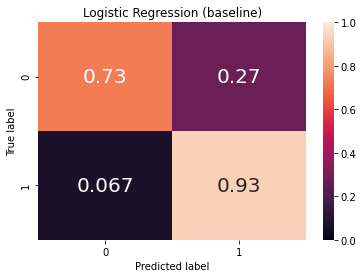

<IPython.core.display.Javascript object>

In [125]:
cm = confusion_matrix(y_test, lr_pred)
plot_confusion_matrix(cm, classes=lr.classes_, title="Logistic Regression (baseline)")
print(classification_report(y_test, lr_pred))

Baseline model does quite well with 0.83 f1 and 0.83 weighted recall. Lets see its feature importance:

In [126]:
eli5.explain_weights(
    lr, feature_names=list(x.columns),
)

Explanation(estimator='LogisticRegression()', description="\nFeatures with largest coefficients.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='emp_length', weight=0.13482109638008247, std=None, value=None), FeatureWeight(feature='fico', weight=0.0223896117813057, std=None, value=None)], neg=[FeatureWeight(feature='<BIAS>', weight=-14.269407474670519, std=None, value=None), FeatureWeight(feature='dti', weight=-0.030521852887822568, std=None, value=None), FeatureWeight(feature='loan_amnt', weight=-2.4398741818513666e-05, std=None, value=None)], pos_remaining=0, neg_remaining=0), proba=None, score=None, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

<IPython.core.display.Javascript object>

In [127]:
eli5.show_prediction(lr, X_test.iloc[1009], feature_names=list(x.columns))

<IPython.core.display.Javascript object>

Even though our F1 score seems to be good, from the model interpretation we can see that BIAS contribution is too high for the selected features, lets add our categorical features, and create a pipeline to do the encoding and scaling.

#### Logistic Regression pipeline

We are going to create dictionaries for state column. The encode number given to each state is based on mean value of 'paid' column. The higher mean 'paid' value is, the greater number is used as an encoder.

In [128]:
state_dict = (
    first_step_df.groupby("addr_state")["paid"]
    .mean()
    .reset_index()
    .sort_values(by="paid", ignore_index=True)
    .drop(labels="paid", axis=1)
    .to_dict(orient="dict")["addr_state"]
)
state_dict = dict((v, k) for k, v in state_dict.items())
state_cat = [[*state_dict]]

<IPython.core.display.Javascript object>

In [129]:
# Preprocessing pipeline

numeric_features = ["loan_amnt", "fico", "dti", "emp_length"]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

state_transformer = OrdinalEncoder(categories=state_cat)
purpose_transformer = OneHotEncoder(handle_unknown="ignore")
# purpose_transformer = OrdinalEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("purpose", purpose_transformer, ["purpose"]),
        ("state", state_transformer, ["addr_state"]),
    ]
)

<IPython.core.display.Javascript object>

In [130]:
# Create our Logistic Regression pipeline with preprocessor
clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(max_iter=1000)),
    ]
)

x = first_step_df.drop(["paid"], axis=1)
y = first_step_df["paid"]

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42
)

clf.fit(X_train, y_train)
clf_pred = clf.predict(X_test)

<IPython.core.display.Javascript object>

              precision    recall  f1-score   support

           0       0.92      0.74      0.82    320825
           1       0.78      0.93      0.85    323332

    accuracy                           0.84    644157
   macro avg       0.85      0.84      0.83    644157
weighted avg       0.85      0.84      0.83    644157



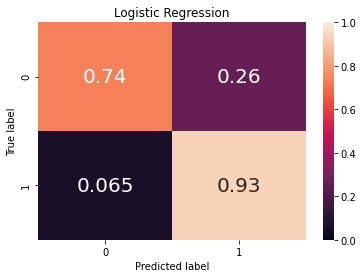

<IPython.core.display.Javascript object>

In [131]:
cm = confusion_matrix(y_test, clf_pred)
plot_confusion_matrix(cm, classes=clf.classes_, title="Logistic Regression")
print(classification_report(y_test, clf_pred))

F1 remained the same, recall have improved a little, lets see feature weights:

In [132]:
eli5.explain_weights(
    clf.named_steps["classifier"], feature_names=get_feature_names(preprocessor)
)

Explanation(estimator='LogisticRegression(max_iter=1000)', description="\nFeatures with largest coefficients.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='num__fico', weight=6.472067736307142, std=None, value=None), FeatureWeight(feature='purpose__x0_credit_card', weight=1.4338391345498382, std=None, value=None), FeatureWeight(feature='purpose__x0_debt_consolidation', weight=0.8200574897974314, std=None, value=None), FeatureWeight(feature='purpose__x0_wedding', weight=0.7798477599798382, std=None, value=None), FeatureWeight(feature='purpose__x0_home_improvement', weight=0.7094054284676459, std=None, value=None), FeatureWeight(feature='num__emp_length', weight=0.49471358014970623, std=None, value=None), FeatureWeight(feature='purpose__x0_renewable_energy', weight=0.38814428217167896, std=None, value=None), FeatureWeight(feature='purpose__x0_major_purchase', weight=0.37290588801686697, std=None, value=None), FeatureWeight(feature='purpose__x0_vacation', weight=0.2745337304507081, std=None, value=None), FeatureWeight(feature='purpose__x0_other', weight=0.16994124907236788, std=None, value=None), FeatureWeight(feature='purpose__x0_medical', weight=0.16756149576246113, std=None, value=None)], neg=[FeatureWeight(feature='<BIAS>', weight=-3.8989106918867784, std=None, value=None), FeatureWeight(feature='purpose__x0_personal', weight=-3.6646459016009656, std=None, value=None), FeatureWeight(feature='purpose__x0_Green loan', weight=-3.5470869948850874, std=None, value=None), FeatureWeight(feature='purpose__x0_car', weight=-1.0174093556083512, std=None, value=None), FeatureWeight(feature='num__dti', weight=-0.41706400944370176, std=None, value=None), FeatureWeight(feature='purpose__x0_educational', weight=-0.364219496531999, std=None, value=None), FeatureWeight(feature='num__loan_amnt', weight=-0.3597782461542627, std=None, value=None), FeatureWeight(feature='purpose__x0_small_business', weight=-0.16528228546573107, std=None, value=None), FeatureWeight(feature='purpose__x0_house', weight=-0.10351618080177909, std=None, value=None)], pos_remaining=2, neg_remaining=0), proba=None, score=None, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

<IPython.core.display.Javascript object>

Bias has significantly decreased, FICO and employment length are still one of the main features, however purpose looks like important one as well.

In [133]:
xgb = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", XGBClassifier(objective="binary:logistic", eval_metric="auc")),
    ]
)

x = first_step_df.drop(["paid"], axis=1)
y = first_step_df["paid"]

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42
)

xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
f1_score(y_test, xgb_pred)

0.883298433139627

<IPython.core.display.Javascript object>

              precision    recall  f1-score   support

           0       0.99      0.74      0.85    320825
           1       0.80      0.99      0.88    323332

    accuracy                           0.87    644157
   macro avg       0.89      0.87      0.87    644157
weighted avg       0.89      0.87      0.87    644157



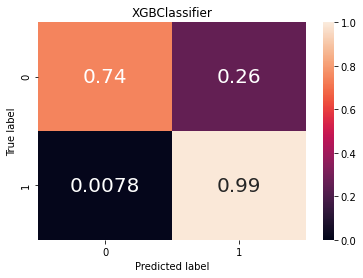

<IPython.core.display.Javascript object>

In [134]:
cm = confusion_matrix(y_test, xgb_pred)
plot_confusion_matrix(cm, classes=xgb.classes_, title="XGBClassifier")
print(classification_report(y_test, xgb_pred))

XGBClassifier has achieved the best F1 score as well as recall, lets try to do hyperparameter tuning as for last step

In [135]:
pickle_out = open("charged_off_xgb.pkl", "wb")
pickle.dump(xgb, pickle_out)
pickle_out.close()

<IPython.core.display.Javascript object>

In [136]:
# booster = ["gbtree", "gblinear", "dart"]
# learning_rate = [0.1, 0.3, 0.5, 0.7]
# gamma = [0, 1, 2, 3, 4]

# xgb_param_grid = {
#    "classifier__booster": booster,
#    "classifier__learning_rate": learning_rate,
# }
# random = RandomizedSearchCV(xgb, xgb_param_grid, n_iter=100, scoring="f1", n_jobs=-1)
# random.fit(X_train, y_train)

<IPython.core.display.Javascript object>

There was no improvement after hyperparameter tuning, so we will keep the default XGBClassifier model

## STEP 2: Grade prediction

We are only interested in Fully Paid loans, as those records carry the correctly assigned Grade.

In [137]:
grade_pred_df = lend_club_df[lend_club_df["paid"] == 1]

<IPython.core.display.Javascript object>

Drop 'Paid' status columns, as well as third step columns 'int_rate' and 'sub_grade'

In [138]:
grade_pred_df.drop(labels=["paid", "int_rate", "sub_grade"], axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [139]:
grade_pred_df.grade.value_counts()

B    340251
C    296300
A    220899
D    140271
E     57934
F     17705
G      4684
Name: grade, dtype: int64

<IPython.core.display.Javascript object>

#### Preprocessing pipeline

In [140]:
# Preprocessing pipeline

numeric_features = [
    "loan_amnt",
    "fico",
    "dti",
    "emp_length",
    "annual_inc",
    "pub_rec",
    "total_acc",
    "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op",
    "mort_acc",
]
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant",)),
        ("scaler", StandardScaler()),
    ]
)

cat_features = [
    "term",
    "home_ownership",
    "verification_status",
    "initial_list_status",
    "application_type",
]
cat_transformer = OneHotEncoder(handle_unknown="ignore")
state_transformer = OrdinalEncoder(categories=state_cat)
purpose_transformer = OneHotEncoder(handle_unknown="ignore")
# purpose_transformer = OrdinalEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("purpose", purpose_transformer, ["purpose"]),
        ("state", state_transformer, ["addr_state"]),
        ("cat", cat_transformer, cat_features),
    ]
)

<IPython.core.display.Javascript object>

#### Baseline Model

In [141]:
lr_clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "lr_classifier",
            OneVsRestClassifier(LogisticRegression(solver="sag"), n_jobs=-1),
        ),
    ]
)

x = grade_pred_df.drop(["grade"], axis=1)
y = grade_pred_df["grade"]


X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42
)

lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)

<IPython.core.display.Javascript object>

In [142]:
print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           A       0.63      0.62      0.62     66297
           B       0.44      0.61      0.51    101823
           C       0.39      0.49      0.43     89099
           D       0.28      0.02      0.04     41902
           E       0.27      0.01      0.02     17406
           F       0.00      0.00      0.00      5452
           G       0.00      0.00      0.00      1435

    accuracy                           0.46    323414
   macro avg       0.29      0.25      0.23    323414
weighted avg       0.42      0.46      0.41    323414



<IPython.core.display.Javascript object>

In [143]:
rf_clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("rf_classifier", OneVsRestClassifier(RandomForestClassifier(), n_jobs=-1),),
    ]
)

rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)

<IPython.core.display.Javascript object>

In [144]:
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           A       0.66      0.63      0.65     66297
           B       0.47      0.59      0.52    101823
           C       0.42      0.50      0.46     89099
           D       0.36      0.17      0.23     41902
           E       0.35      0.13      0.19     17406
           F       0.36      0.05      0.09      5452
           G       0.45      0.01      0.03      1435

    accuracy                           0.48    323414
   macro avg       0.44      0.30      0.31    323414
weighted avg       0.47      0.48      0.46    323414



<IPython.core.display.Javascript object>

In [145]:
xgb_clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "xgb_classifier",
            OneVsRestClassifier(
                XGBClassifier(objective="binary:logistic", eval_metric="auc"), n_jobs=-1
            ),
        ),
    ]
)


xgb_clf.fit(X_train, y_train)
xgb_pred = xgb_clf.predict(X_test)

<IPython.core.display.Javascript object>

In [146]:
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           A       0.67      0.64      0.66     66297
           B       0.48      0.62      0.54    101823
           C       0.43      0.51      0.47     89099
           D       0.40      0.17      0.23     41902
           E       0.37      0.14      0.21     17406
           F       0.38      0.05      0.09      5452
           G       0.36      0.02      0.05      1435

    accuracy                           0.50    323414
   macro avg       0.44      0.31      0.32    323414
weighted avg       0.49      0.50      0.48    323414



<IPython.core.display.Javascript object>

In [147]:
# le = LabelEncoder()
# grade_pred_df["grade"] = le.fit_transform(grade_pred_df["grade"])

<IPython.core.display.Javascript object>

In [148]:
xgb_clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "xgb_classifier",
            XGBClassifier(objective="multi:softprob", num_class=7, eval_metric="auc"),
        ),
    ]
)


xgb_clf.fit(X_train, y_train)
xgb_pred = xgb_clf.predict(X_test)

<IPython.core.display.Javascript object>

In [149]:
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           A       0.67      0.64      0.66     66297
           B       0.48      0.61      0.54    101823
           C       0.44      0.51      0.47     89099
           D       0.39      0.18      0.24     41902
           E       0.36      0.16      0.22     17406
           F       0.37      0.07      0.12      5452
           G       0.35      0.04      0.07      1435

    accuracy                           0.50    323414
   macro avg       0.44      0.32      0.33    323414
weighted avg       0.49      0.50      0.48    323414



<IPython.core.display.Javascript object>

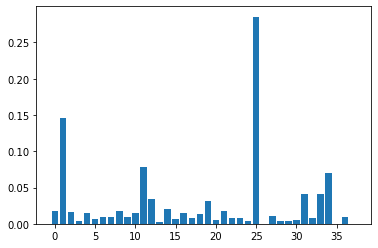

<IPython.core.display.Javascript object>

In [150]:
# plot
plt.bar(
    range(len(xgb_clf.named_steps["xgb_classifier"].feature_importances_)),
    xgb_clf.named_steps["xgb_classifier"].feature_importances_,
)
plt.show()

3 most appearing Grades (A/B/C) have a good enough F1 score, others not so great possibly because of low amount of data for other grades. XGBoostClassifier have the best score here. (feature reduction techniques were implemented, but no improvement)

In [151]:
pickle_out = open("grade_xgb.pkl", "wb")
pickle.dump(xgb_clf, pickle_out)
pickle_out.close()

<IPython.core.display.Javascript object>

## STEP 3: Sub_grade and int_rate prediction

In [152]:
step_three_df = lend_club_df[lend_club_df["paid"] == 1]

<IPython.core.display.Javascript object>

Firstly we are going to predict sub_grade, as for int_rate, lets check if its correlated with sub grade

<AxesSubplot:xlabel='sub_grade', ylabel='int_rate'>

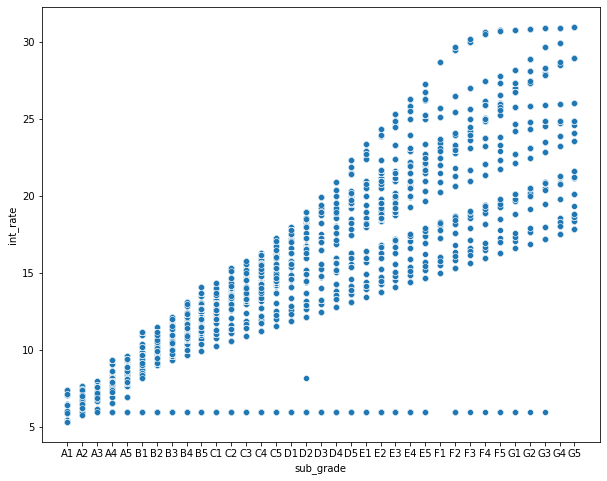

<IPython.core.display.Javascript object>

In [153]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="sub_grade", y="int_rate", data=step_three_df.sort_values(by="sub_grade")
)

The asnwer is obvious, the lower the sub grade, the higher the interest rate, so when predicting interest rate, we are going to use sub_grade as feature. Also we are using grade as a feature for predicting sub_grade

In [154]:
subgrade_pred_df = step_three_df.drop(labels=["paid", "int_rate"], axis=1)

<IPython.core.display.Javascript object>

#### Preprocessing pipeline

In [155]:
# Preprocessing pipeline

numeric_features = [
    "loan_amnt",
    "fico",
    "dti",
    "emp_length",
    "annual_inc",
    "pub_rec",
    "total_acc",
    "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op",
    "mort_acc",
]
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant",)),
        ("scaler", StandardScaler()),
    ]
)

cat_features = [
    "term",
    "home_ownership",
    "verification_status",
    "initial_list_status",
    "application_type",
]
cat_transformer = OneHotEncoder(handle_unknown="ignore")
state_transformer = OrdinalEncoder(categories=state_cat)
purpose_transformer = OneHotEncoder(handle_unknown="ignore")
grade_transformer = OrdinalEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("purpose", purpose_transformer, ["purpose"]),
        ("state", state_transformer, ["addr_state"]),
        ("cat", cat_transformer, cat_features),
        ("grade", grade_transformer, ["grade"]),
    ]
)

<IPython.core.display.Javascript object>

In [156]:
lr_clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "lr_classifier",
            OneVsRestClassifier(LogisticRegression(solver="sag"), n_jobs=-1),
        ),
    ]
)

x = subgrade_pred_df.drop(["sub_grade"], axis=1)
y = subgrade_pred_df["sub_grade"]


X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42
)

lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)

<IPython.core.display.Javascript object>

In [157]:
print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

          A1       0.37      0.65      0.47     12676
          A2       0.25      0.01      0.02     10701
          A3       0.24      0.00      0.00     10793
          A4       0.25      0.08      0.12     14613
          A5       0.37      0.80      0.50     17514
          B1       0.26      0.43      0.32     18975
          B2       0.22      0.05      0.08     19794
          B3       0.23      0.21      0.22     21349
          B4       0.26      0.14      0.18     21287
          B5       0.23      0.50      0.32     20418
          C1       0.18      0.72      0.29     20780
          C2       0.14      0.03      0.04     19032
          C3       0.11      0.02      0.04     17575
          C4       0.13      0.26      0.17     16829
          C5       0.16      0.07      0.09     14883
          D1       0.01      0.02      0.01     11036
          D2       0.02      0.00      0.00      9453
          D3       0.05    

<IPython.core.display.Javascript object>

In [158]:
pickle_out = open("sub_grade_lr.pkl", "wb")
pickle.dump(lr_clf, pickle_out)
pickle_out.close()

<IPython.core.display.Javascript object>

#### Predicting int_rate

In [159]:
int_rate_pred_df = step_three_df.drop(labels=["paid"], axis=1)

<IPython.core.display.Javascript object>

In [160]:
# Preprocessing pipeline

numeric_features = [
    "loan_amnt",
    "fico",
    "dti",
    "emp_length",
    "annual_inc",
    "pub_rec",
    "total_acc",
    "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op",
    "mort_acc",
]
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant",)),
        ("scaler", StandardScaler()),
    ]
)

cat_features = [
    "term",
    "home_ownership",
    "verification_status",
    "initial_list_status",
    "application_type",
]
cat_transformer = OneHotEncoder(handle_unknown="ignore")
state_transformer = OrdinalEncoder(categories=state_cat)
purpose_transformer = OneHotEncoder(handle_unknown="ignore")
grade_transformer = OrdinalEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("purpose", purpose_transformer, ["purpose"]),
        ("state", state_transformer, ["addr_state"]),
        ("cat", cat_transformer, cat_features),
        ("grade", grade_transformer, ["grade", "sub_grade"]),
    ]
)

<IPython.core.display.Javascript object>

In [161]:
lr_reg = Pipeline(
    steps=[("preprocessor", preprocessor), ("lr_regressor", LinearRegression()),]
)

x = int_rate_pred_df.drop(["int_rate"], axis=1)
y = int_rate_pred_df["int_rate"]


X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42
)

lr_reg.fit(X_train, y_train)
lr_pred = lr_reg.predict(X_test)

<IPython.core.display.Javascript object>

In [162]:
r2_score(y_test, lr_pred)

0.9542121398793703

<IPython.core.display.Javascript object>

In [163]:
pickle_out = open("int_rate_lreg.pkl", "wb")
pickle.dump(lr_reg, pickle_out)
pickle_out.close()

<IPython.core.display.Javascript object>

## Conclusion

- We were able to achieve a high accuracy model for the first step either Accept or Reject loan
- FICO and DTI seems to be the most important features, followed by purpose
- Grade and Sub Grade models are quite poor accuracy, because having too many classes with low amount of data for low grades (E-G)
- Interest rate model is of high accuracy
- Models could be improved if more recent data were gathered, to keep it relevant